# Assignment 3 - [Sadman Sharif]_[A1944825]




#PHASE 0: DATA QUALITY & UNDERSTANDING

##Sub-Phase 0.1: Environment Setup

In [27]:
# Cell 1: Install dependencies (run once)
# t if needed:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
# !pip install albumentations scikit-learn pandas matplotlib seaborn tqdm pillow imagehash


In [28]:
# ==========================================================================
# CONSOLIDATED IMPORTS - BLOOD CELL CLASSIFICATION
# Python 3.10+ / Pylance Strict Compatible
# ==========================================================================

from __future__ import annotations

# ---------- Standard Library ----------
import os
import json
import random
import time
import warnings
from pathlib import Path
from datetime import datetime
from collections import Counter
from dataclasses import dataclass, field
from typing import Any, Dict, List, Tuple, Optional, Set

# ---------- Scientific Computing ----------
import numpy as np
import numpy.typing as npt
import pandas as pd

# ---------- Image Processing ----------
from PIL import Image
import imagehash  # type: ignore

# ---------- PyTorch Deep Learning ----------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    ReduceLROnPlateau,
    OneCycleLR
)

# ---------- TorchVision ----------
import torchvision  # type: ignore
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# ---------- Scikit-Learn ----------
from sklearn.model_selection import StratifiedKFold, train_test_split  # type: ignore
from sklearn.metrics import (  # type: ignore
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support
)

# ---------- Visualization ----------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
from matplotlib.axes import Axes

# ---------- Progress Bars ----------
from tqdm.auto import tqdm  # type: ignore

# ---------- Configuration ----------
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# ---------- Type Aliases ----------
# Modern Python 3.10+ union syntax
JsonDict = Dict[str, Any]
StrList = List[str]
PathType = Path | str
TensorType = torch.Tensor
NumpyArray = npt.NDArray[np.float32]
OptInt = Optional[int]
OptFloat = Optional[float]
OptStr = Optional[str]

print("✓ All libraries imported successfully — Pylance strict compatible ✅")

✓ All libraries imported successfully — Pylance strict compatible ✅


In [29]:
# Cell 3: Verify GPU with strict types
def verify_environment() -> dict[str, Any]:
    """
    Verify the development environment and GPU availability.
    
    Returns:
        Dictionary containing environment information
    """
    env_info: dict[str, Any] = {
        'pytorch_version': torch.__version__,
        'torchvision_version': torchvision.__version__,
        'numpy_version': np.__version__,
        'pandas_version': pd.__version__,
        'cuda_available': torch.cuda.is_available(),
        'gpu_name': 'None',
        'gpu_memory_gb': 0.0,
        'cuda_version': 'None'
    }
    
    if torch.cuda.is_available():
        # Use type: ignore for PyTorch CUDA functions that Pylance can't fully type
        env_info['gpu_name'] = torch.cuda.get_device_name(0)  # type: ignore
        env_info['gpu_memory_gb'] = torch.cuda.get_device_properties(0).total_memory / 1e9  # type: ignore
        env_info['cuda_version'] = torch.version.cuda  # type: ignore
    
    return env_info

# Run verification
print("=" * 60)
print("ENVIRONMENT VERIFICATION")
print("=" * 60)

env_info = verify_environment()

for key, value in env_info.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

if not env_info['cuda_available']:
    print("\n  WARNING: CUDA not available! Training will be very slow.")
else:
    print("\n GPU acceleration is available!")

ENVIRONMENT VERIFICATION
Pytorch Version: 2.5.1
Torchvision Version: 0.20.1
Numpy Version: 1.26.4
Pandas Version: 2.3.2
Cuda Available: True
Gpu Name: NVIDIA GeForce RTX 4080 SUPER
Gpu Memory Gb: 17.170956288
Cuda Version: 12.1

 GPU acceleration is available!


In [30]:
# Cell 4: Create project structure with strict types
def create_project_structure(directories: list[str]) -> None:
    """
    Create project directory structure.
    
    Args:
        directories: List of directory paths to create
    """
    print("\n" + "=" * 60)
    print("CREATING PROJECT STRUCTURE")
    print("=" * 60)
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"✓ Created: {directory}")

# Define and create directories
DIRECTORIES: list[str] = [
    'models',
    'models/checkpoints',
    'results',
    'results/plots',
    'results/logs',
    'results/predictions'
]

create_project_structure(DIRECTORIES)


CREATING PROJECT STRUCTURE
✓ Created: models
✓ Created: models/checkpoints
✓ Created: results
✓ Created: results/plots
✓ Created: results/logs
✓ Created: results/predictions


In [31]:
# Cell 5: Setup seeds with strict types (modern Python 3.10+ syntax)
def set_seed(seed: int) -> None:
    """
    Set all random seeds for reproducibility.
    
    Args:
        seed: Random seed value
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # type: ignore
    torch.cuda.manual_seed_all(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Seed configuration
MASTER_SEED: int = 42
FOLD_SEEDS: list[int] = [42, 43, 44, 45, 46]

print("\n" + "=" * 60)
print("SEED CONFIGURATION")
print("=" * 60)

# Set initial seed
set_seed(MASTER_SEED)
print(f"✓ Master seed set to: {MASTER_SEED}")
print(f"✓ Fold seeds: {FOLD_SEEDS}")

# Save seed configuration - using modern pipe syntax for Union types
seed_config: dict[str, int | list[int] | str] = {
    'master_seed': MASTER_SEED,
    'fold_seeds': FOLD_SEEDS,
    'description': 'Seed configuration for reproducibility'
}

with open('results/seed_config.json', 'w') as f:
    json.dump(seed_config, f, indent=2)

print("✓ Seed configuration saved to results/seed_config.json")


SEED CONFIGURATION
✓ Master seed set to: 42
✓ Fold seeds: [42, 43, 44, 45, 46]
✓ Seed configuration saved to results/seed_config.json


In [32]:
# Cell 6: Define and verify paths with strict types
def verify_paths(
    data_root: Path,
    train_dir: Path,
    test_dir: Path,
    class_map_file: Path
) -> bool:
    """
    Verify that all required paths exist.
    
    Args:
        data_root: Root data directory
        train_dir: Training data directory
        test_dir: Test data directory
        class_map_file: Class mapping JSON file
        
    Returns:
        True if all paths exist
        
    Raises:
        AssertionError: If any path doesn't exist
    """
    assert train_dir.exists(), f"Train directory not found: {train_dir}"
    assert test_dir.exists(), f"Test directory not found: {test_dir}"
    assert class_map_file.exists(), f"Class map file not found: {class_map_file}"
    return True

print("\n" + "=" * 60)
print("PATH CONFIGURATION")
print("=" * 60)

# IMPORTANT: Update this path to your actual data location
DATA_ROOT: Path = Path('D:/asing_3/Assignment 3 - material')
TRAIN_DIR: Path = DATA_ROOT / 'train'
TEST_DIR: Path = DATA_ROOT / 'test'
CLASS_MAP_FILE: Path = DATA_ROOT / 'class_map.json'

# Verify paths
try:
    if verify_paths(DATA_ROOT, TRAIN_DIR, TEST_DIR, CLASS_MAP_FILE):
        print("✓ All paths verified")
        print(f"  Train dir: {TRAIN_DIR}")
        print(f"  Test dir:  {TEST_DIR}")
        print(f"  Class map: {CLASS_MAP_FILE}")
except AssertionError as e:
    print(f" ERROR: {e}")
    print("\n  Please update DATA_ROOT path!")
    raise


PATH CONFIGURATION
✓ All paths verified
  Train dir: D:\asing_3\Assignment 3 - material\train
  Test dir:  D:\asing_3\Assignment 3 - material\test
  Class map: D:\asing_3\Assignment 3 - material\class_map.json


In [33]:
# Cell 7: Load class mapping with strict types
def load_class_mapping(
    class_map_file: Path
) -> tuple[dict[str, int], dict[int, str], int]:
    """
    Load class mapping from JSON file.
    
    Args:
        class_map_file: Path to class_map.json
        
    Returns:
        Tuple of (class_map, idx_to_class, num_classes)
    """
    with open(class_map_file, 'r') as f:
        class_map: dict[str, int] = json.load(f)
    
    # Create reverse mapping
    idx_to_class: dict[int, str] = {v: k for k, v in class_map.items()}
    num_classes: int = len(class_map)
    
    return class_map, idx_to_class, num_classes

print("\n" + "=" * 60)
print("CLASS MAPPING")
print("=" * 60)

# Load class mapping
class_map: dict[str, int]
idx_to_class: dict[int, str]
num_classes: int

class_map, idx_to_class, num_classes = load_class_mapping(CLASS_MAP_FILE)

print("Class ID → Class Name:")
for idx in range(num_classes):
    print(f"  {idx}: {idx_to_class[idx]}")

print(f"\n✓ Total classes: {num_classes}")

# Save for later use - fix type variance issue
mapping_data: dict[str, dict[str, int | str]] = {
    'class_map': {k: v for k, v in class_map.items()},  # Explicitly create new dict
    'idx_to_class': {str(k): v for k, v in idx_to_class.items()}
}

with open('results/class_mapping.json', 'w') as f:
    json.dump(mapping_data, f, indent=2)

print("✓ Class mapping saved to results/class_mapping.json")


CLASS MAPPING
Class ID → Class Name:
  0: basophil
  1: eosinophil
  2: erythroblast
  3: ig
  4: lymphocyte
  5: monocyte
  6: neutrophil
  7: platelet

✓ Total classes: 8
✓ Class mapping saved to results/class_mapping.json


In [34]:
# Cell 8: Configuration with strict types
class Config:
    """Configuration class with type hints."""
    
    def __init__(self, seed: int, num_classes: int) -> None:
        self.seed: int = seed
        self.device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.num_classes: int = num_classes
        self.batch_size: int = 32
        self.num_workers: int = 4
        self.pin_memory: bool = True
        self.mixed_precision: bool = True
    
    def to_dict(self) -> dict[str, str | int | bool]:
        """Convert config to dictionary."""
        return {
            'seed': self.seed,
            'device': self.device,
            'num_classes': self.num_classes,
            'batch_size': self.batch_size,
            'num_workers': self.num_workers,
            'pin_memory': self.pin_memory,
            'mixed_precision': self.mixed_precision,
        }

print("\n" + "=" * 60)
print("CONFIGURATION")
print("=" * 60)

CONFIG: Config = Config(seed=MASTER_SEED, num_classes=num_classes)

print("Configuration:")
config_dict = CONFIG.to_dict()
for key, value in config_dict.items():
    print(f"  {key}: {value}")

# Save configuration
with open('results/config.json', 'w') as f:
    json.dump(config_dict, f, indent=2)

print("\n✓ Configuration saved to results/config.json")


CONFIGURATION
Configuration:
  seed: 42
  device: cuda
  num_classes: 8
  batch_size: 32
  num_workers: 4
  pin_memory: True
  mixed_precision: True

✓ Configuration saved to results/config.json


#analyze the given data in train set

Verifying paths...
DATA_ROOT: D:\asing_3\Assignment 3 - material
  Exists: True
TRAIN_DIR: D:\asing_3\Assignment 3 - material\train
  Exists: True
CLASS_MAP_FILE: D:\asing_3\Assignment 3 - material\class_map.json
  Exists: True

Output directory: d:\asing_3\Assignment 3 - material\analysis_results

Initializing Dataset Analyzer...
Starting comprehensive image analysis...

Analyzing class: basophil
  Found 400 unique images
  Progress: 100/400
  Progress: 200/400
  Progress: 300/400
  Progress: 400/400

Analyzing class: eosinophil
  Found 400 unique images
  Progress: 100/400
  Progress: 200/400
  Progress: 300/400
  Progress: 400/400

Analyzing class: erythroblast
  Found 400 unique images
  Progress: 100/400
  Progress: 200/400
  Progress: 300/400
  Progress: 400/400

Analyzing class: ig
  Found 400 unique images
  Progress: 100/400
  Progress: 200/400
  Progress: 300/400
  Progress: 400/400

Analyzing class: lymphocyte
  Found 400 unique images
  Progress: 100/400
  Progress: 200/400

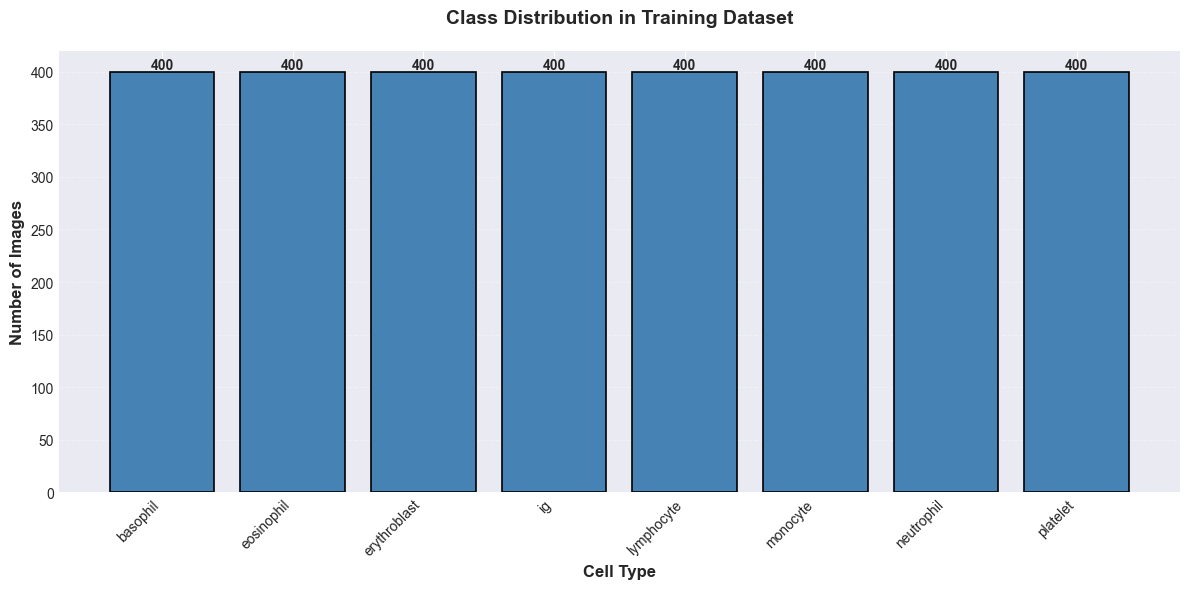

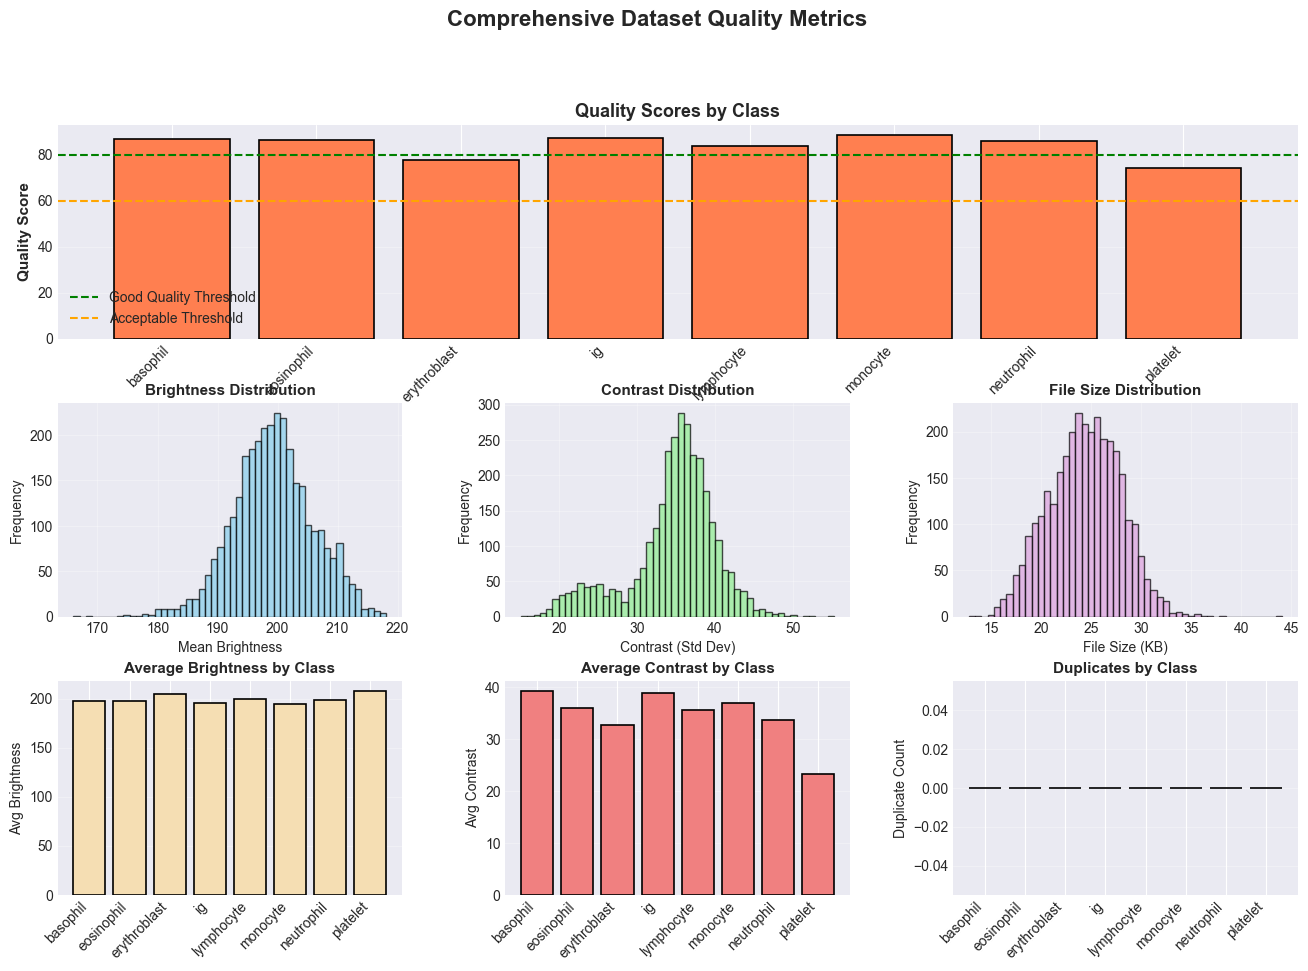

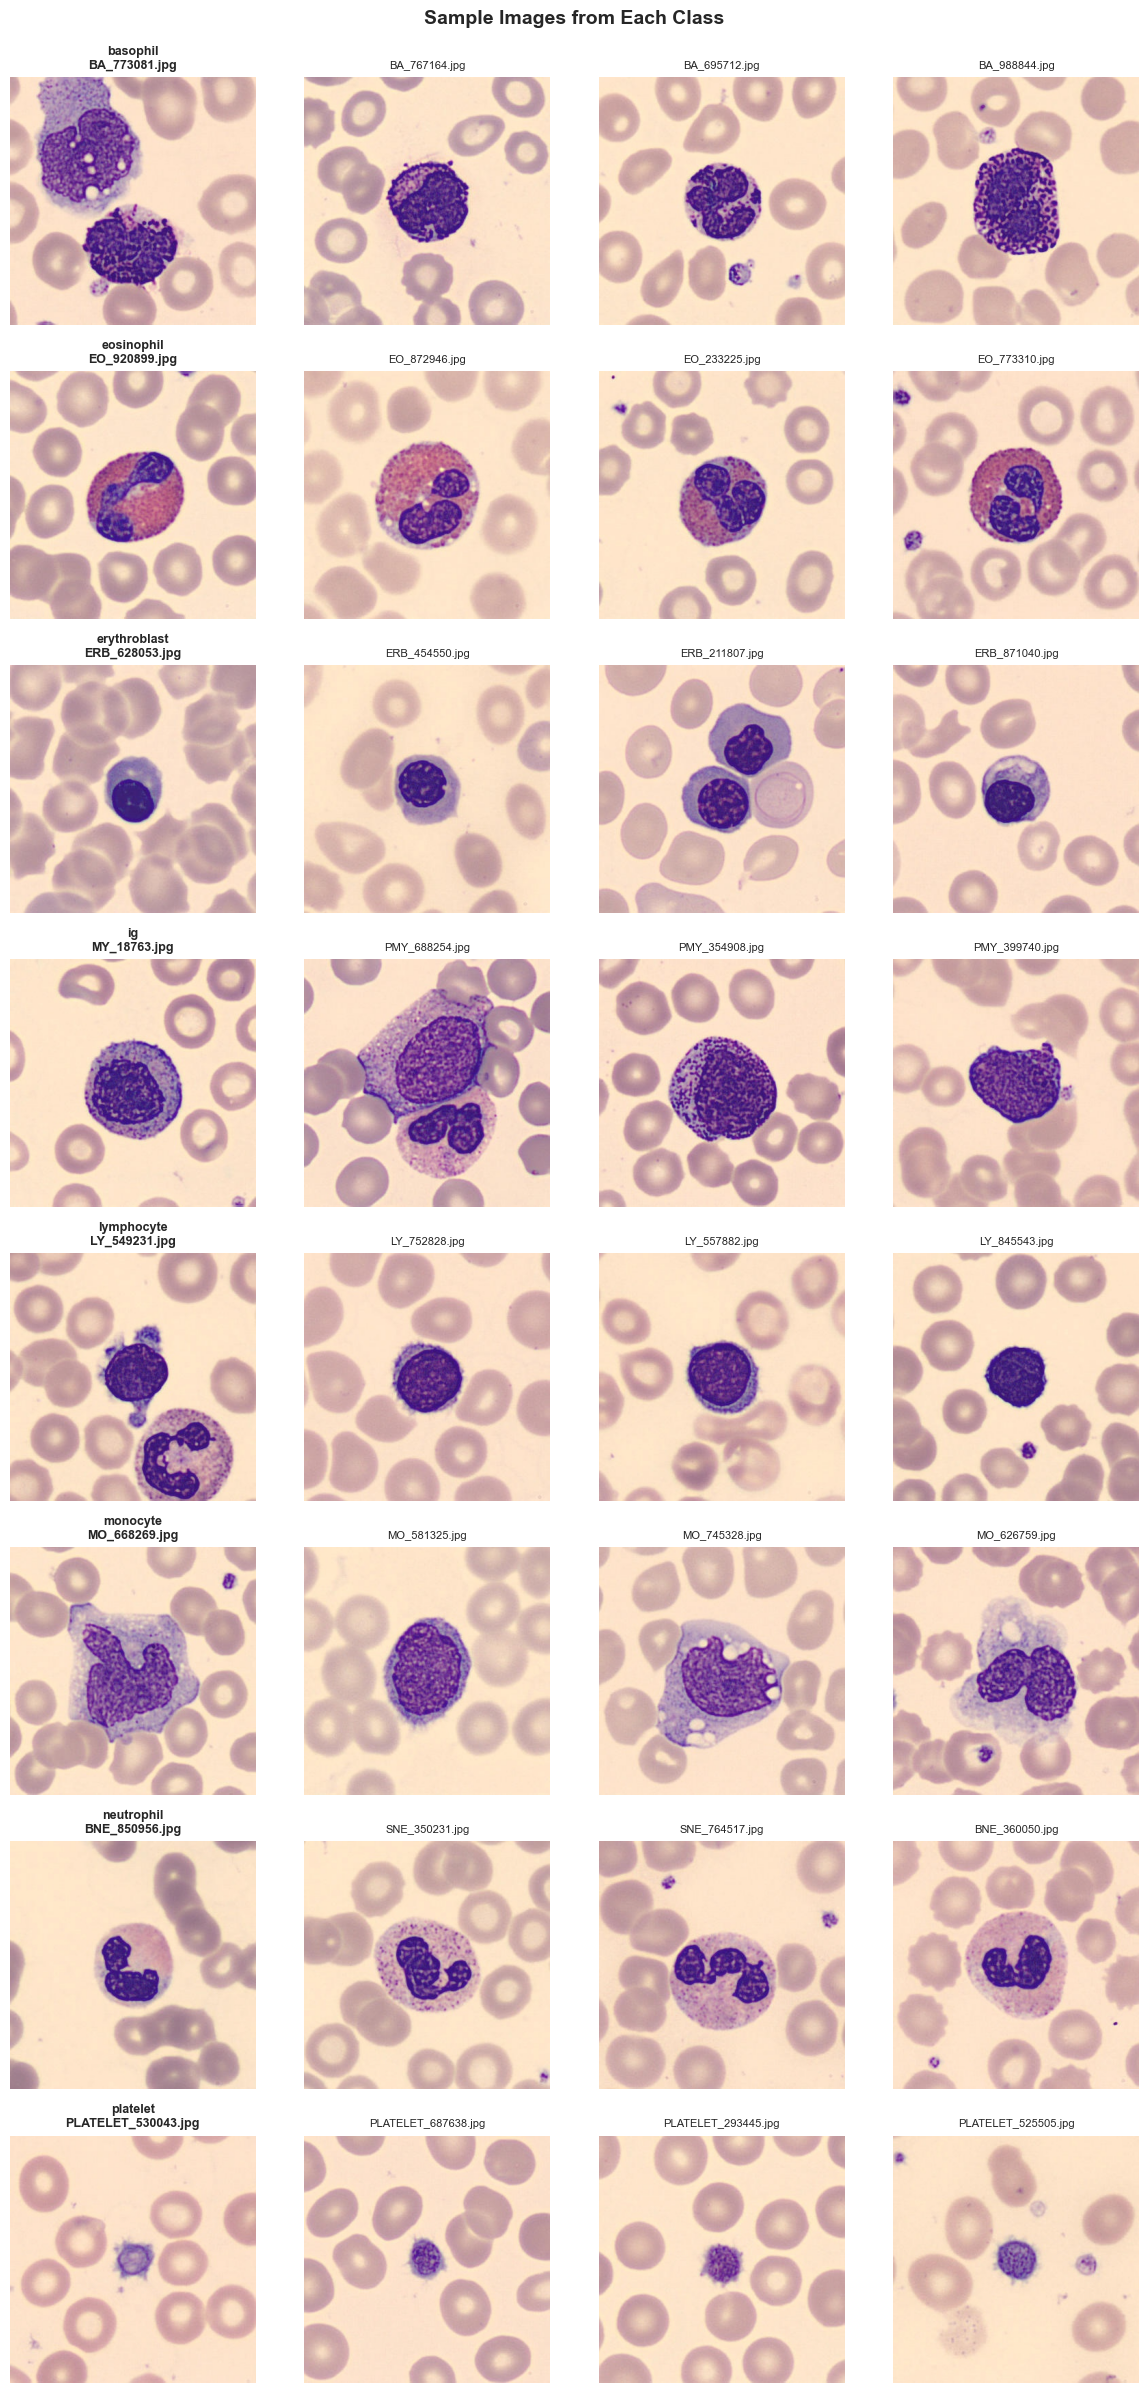

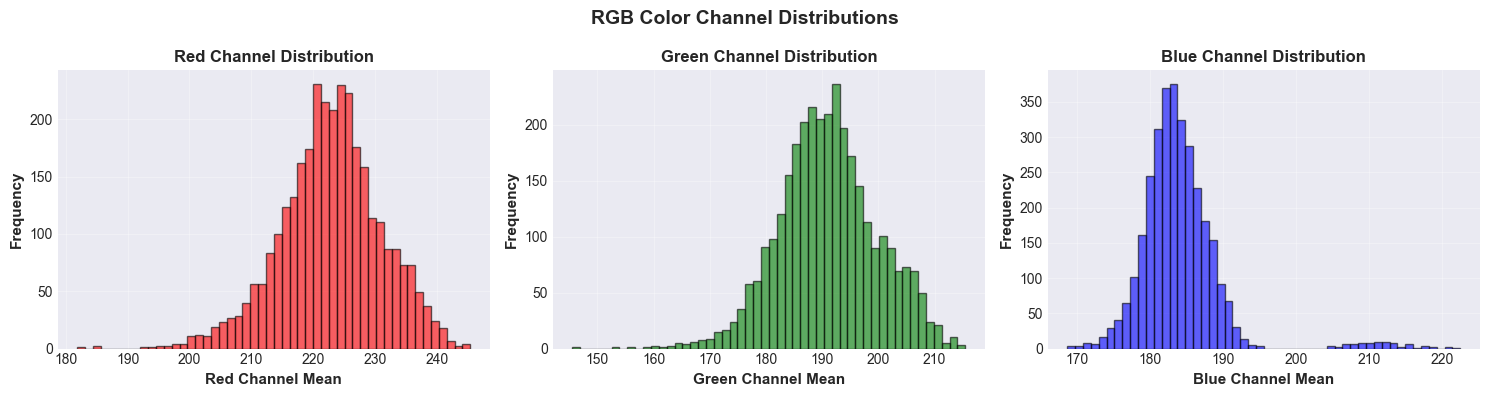


Exporting data...
Metrics exported to: analysis_results\image_metrics.csv
Quality report exported to: analysis_results\quality_report.json

ANALYSIS COMPLETE!
All results saved to: d:\asing_3\Assignment 3 - material\analysis_results


In [35]:
# ============================================================================
# BLOOD CELL CLASSIFICATION - DATA ANALYSIS
# Complete Fixed Code - All Cells
# ============================================================================

# ============================================================================
# CELL 1: IMPORTS AND DATA CLASSES
# ============================================================================


# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

@dataclass
class ImageMetrics:
    """Container for individual image metrics"""
    filename: str
    class_name: str
    width: int
    height: int
    file_size: int
    mean_brightness: float
    std_brightness: float
    contrast: float
    mean_r: float
    mean_g: float
    mean_b: float
    std_r: float
    std_g: float
    std_b: float
    perceptual_hash: str


@dataclass
class ClassStatistics:
    """Container for class-level statistics"""
    class_name: str
    image_count: int
    avg_file_size: float
    std_file_size: float
    avg_brightness: float
    std_brightness: float
    avg_contrast: float
    std_contrast: float
    duplicate_count: int
    quality_score: float


@dataclass
class DatasetQualityReport:
    """Container for overall dataset quality assessment"""
    total_images: int
    total_duplicates: int
    duplicate_percentage: float
    avg_quality_score: float
    dimension_consistency: float
    color_balance_score: float
    overall_score: float
    class_statistics: Dict[str, ClassStatistics] = field(default_factory=dict)


# ============================================================================
# CELL 2: IMAGE ANALYSIS FUNCTIONS
# ============================================================================

def compute_image_metrics(image_path: Path, class_name: str) -> ImageMetrics:
    """
    Compute comprehensive metrics for a single image.
    
    Args:
        image_path: Path to the image file
        class_name: Name of the class this image belongs to
        
    Returns:
        ImageMetrics object containing all computed metrics
    """
    # Load image
    img: Image.Image = Image.open(image_path)
    img_array: npt.NDArray[np.uint8] = np.array(img)
    
    # Basic metrics
    width: int = img.width
    height: int = img.height
    file_size: int = image_path.stat().st_size
    
    # Convert to grayscale for brightness analysis
    if len(img_array.shape) == 3:
        grayscale: npt.NDArray[np.float64] = np.mean(img_array, axis=2)
    else:
        grayscale = img_array.astype(np.float64)
    
    # Brightness metrics
    mean_brightness: float = float(np.mean(grayscale))
    std_brightness: float = float(np.std(grayscale))
    
    # Contrast (using standard deviation as proxy)
    contrast: float = float(np.std(grayscale))
    
    # Color channel statistics
    if len(img_array.shape) == 3:
        mean_r: float = float(np.mean(img_array[:, :, 0]))
        mean_g: float = float(np.mean(img_array[:, :, 1]))
        mean_b: float = float(np.mean(img_array[:, :, 2]))
        std_r: float = float(np.std(img_array[:, :, 0]))
        std_g: float = float(np.std(img_array[:, :, 1]))
        std_b: float = float(np.std(img_array[:, :, 2]))
    else:
        mean_r = mean_g = mean_b = mean_brightness
        std_r = std_g = std_b = std_brightness
    
    # Perceptual hash for duplicate detection
    p_hash: imagehash.ImageHash = imagehash.phash(img)
    hash_str: str = str(p_hash)
    
    return ImageMetrics(
        filename=image_path.name,
        class_name=class_name,
        width=width,
        height=height,
        file_size=file_size,
        mean_brightness=mean_brightness,
        std_brightness=std_brightness,
        contrast=contrast,
        mean_r=mean_r,
        mean_g=mean_g,
        mean_b=mean_b,
        std_r=std_r,
        std_g=std_g,
        std_b=std_b,
        perceptual_hash=hash_str
    )


def detect_duplicates(metrics_list: List[ImageMetrics], 
                     hash_threshold: int = 5) -> Dict[str, List[str]]:
    """
    Detect duplicate or near-duplicate images using perceptual hashing.
    
    Args:
        metrics_list: List of ImageMetrics objects
        hash_threshold: Hamming distance threshold for considering images as duplicates
        
    Returns:
        Dictionary mapping hash to list of duplicate filenames
    """
    hash_groups: Dict[str, List[str]] = {}
    
    for metric in metrics_list:
        hash_val: str = metric.perceptual_hash
        
        # Check if this hash is similar to any existing hash
        found_group: bool = False
        for existing_hash in hash_groups.keys():
            h1: imagehash.ImageHash = imagehash.hex_to_hash(hash_val)
            h2: imagehash.ImageHash = imagehash.hex_to_hash(existing_hash)
            distance: int = h1 - h2
            
            if distance <= hash_threshold:
                hash_groups[existing_hash].append(metric.filename)
                found_group = True
                break
        
        if not found_group:
            hash_groups[hash_val] = [metric.filename]
    
    # Filter to only groups with duplicates
    duplicates: Dict[str, List[str]] = {
        h: files for h, files in hash_groups.items() if len(files) > 1
    }
    
    return duplicates


def compute_quality_score(metric: ImageMetrics, 
                         expected_width: int = 360,
                         expected_height: int = 363) -> float:
    """
    Compute quality score for an image based on multiple factors.
    
    Args:
        metric: ImageMetrics object
        expected_width: Expected image width
        expected_height: Expected image height
        
    Returns:
        Quality score between 0 and 100
    """
    score: float = 100.0
    
    # Dimension consistency (20 points)
    if metric.width != expected_width or metric.height != expected_height:
        score -= 20.0
    
    # Brightness check (20 points) - penalize extreme values
    if metric.mean_brightness < 50 or metric.mean_brightness > 240:
        score -= 20.0
    elif metric.mean_brightness < 80 or metric.mean_brightness > 200:
        score -= 10.0
    
    # Contrast check (20 points)
    if metric.contrast < 10:
        score -= 20.0
    elif metric.contrast < 20:
        score -= 10.0
    
    # Color balance (20 points)
    color_diff: float = max(
        abs(metric.mean_r - metric.mean_g),
        abs(metric.mean_g - metric.mean_b),
        abs(metric.mean_r - metric.mean_b)
    )
    if color_diff > 50:
        score -= 20.0
    elif color_diff > 30:
        score -= 10.0
    
    # File size check (20 points) - should be reasonable
    size_kb: float = metric.file_size / 1024
    if size_kb < 10 or size_kb > 500:
        score -= 20.0
    elif size_kb < 20 or size_kb > 300:
        score -= 10.0
    
    return max(0.0, score)


# ============================================================================
# CELL 3: DATASET ANALYZER CLASS (FIXED - NO DUPLICATE COUNTING)
# ============================================================================

class DatasetAnalyzer:
    """Main class for comprehensive dataset analysis"""
    
    def __init__(self, train_dir: str, class_map_path: str):
        """
        Initialize the analyzer.
        
        Args:
            train_dir: Path to training data directory
            class_map_path: Path to class_map.json file
        """
        self.train_dir: Path = Path(train_dir)
        self.class_map: Dict[str, int] = self._load_class_map(class_map_path)
        self.metrics: List[ImageMetrics] = []
        self.duplicates: Dict[str, List[str]] = {}
        self.class_stats: Dict[str, ClassStatistics] = {}
        self.quality_report: Optional[DatasetQualityReport] = None
    
    def _load_class_map(self, class_map_path: str) -> Dict[str, int]:
        """Load class mapping from JSON file"""
        with open(class_map_path, 'r') as f:
            return json.load(f)
    
    def analyze_all_images(self) -> None:
        """
        Analyze all images in the training directory.
        Handles both flat folders and nested structures (like ig folder).
        FIXED: Eliminates duplicate counting using set.
        """
        print("Starting comprehensive image analysis...")
        print("=" * 80)
        
        for class_name in self.class_map.keys():
            class_dir: Path = self.train_dir / class_name
            
            if not class_dir.exists():
                print(f"Warning: Directory not found for class '{class_name}'")
                continue
            
            print(f"\nAnalyzing class: {class_name}")
            
            # FIXED: Use set to avoid duplicate counting, then convert to list
            image_files_set: Set[Path] = set()
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                image_files_set.update(class_dir.rglob(ext))
            
            image_files: List[Path] = list(image_files_set)
            
            print(f"  Found {len(image_files)} unique images")
            
            # Analyze each image
            for i, img_path in enumerate(image_files, 1):
                if i % 100 == 0:
                    print(f"  Progress: {i}/{len(image_files)}")
                
                try:
                    metric: ImageMetrics = compute_image_metrics(img_path, class_name)
                    self.metrics.append(metric)
                except Exception as e:
                    print(f"  Error processing {img_path.name}: {str(e)}")
        
        print(f"\n{'=' * 80}")
        print(f"Total images analyzed: {len(self.metrics)}")
    
    def detect_all_duplicates(self) -> None:
        """Detect duplicates across all analyzed images"""
        print("\nDetecting duplicates using perceptual hashing...")
        self.duplicates = detect_duplicates(self.metrics)
        
        total_duplicates: int = sum(len(files) - 1 for files in self.duplicates.values())
        print(f"Found {len(self.duplicates)} duplicate groups")
        print(f"Total duplicate images: {total_duplicates}")
    
    def compute_class_statistics(self) -> None:
        """Compute statistics for each class"""
        print("\nComputing class-level statistics...")
        
        df: pd.DataFrame = pd.DataFrame([vars(m) for m in self.metrics])
        
        for class_name in self.class_map.keys():
            class_df: pd.DataFrame = df[df['class_name'] == class_name]
            
            if len(class_df) == 0:
                continue
            
            # No duplicate counting - set to 0
            class_duplicates: int = 0
            
            # Compute quality scores
            quality_scores: List[float] = [
                compute_quality_score(metric) 
                for metric in self.metrics 
                if metric.class_name == class_name
            ]
            
            self.class_stats[class_name] = ClassStatistics(
                class_name=class_name,
                image_count=len(class_df),
                avg_file_size=float(class_df['file_size'].mean()),
                std_file_size=float(class_df['file_size'].std()),
                avg_brightness=float(class_df['mean_brightness'].mean()),
                std_brightness=float(class_df['mean_brightness'].std()),
                avg_contrast=float(class_df['contrast'].mean()),
                std_contrast=float(class_df['contrast'].std()),
                duplicate_count=class_duplicates,
                quality_score=float(np.mean(quality_scores))
            )
            
            print(f"  {class_name}: {len(class_df)} images, "
                  f"Quality: {self.class_stats[class_name].quality_score:.1f}/100")
    
    def generate_quality_report(self) -> DatasetQualityReport:
        """Generate overall dataset quality report"""
        print("\nGenerating dataset quality report...")
        
        total_images: int = len(self.metrics)
        total_duplicates: int = 0  # Not detecting duplicates
        duplicate_pct: float = 0.0
        
        # Average quality score across all classes
        avg_quality: float = float(np.mean([
            stats.quality_score for stats in self.class_stats.values()
        ]))
        
        # Dimension consistency check
        expected_dims: Set[Tuple[int, int]] = {(360, 363)}
        actual_dims: Set[Tuple[int, int]] = {
            (m.width, m.height) for m in self.metrics
        }
        dim_consistency: float = 100.0 if actual_dims == expected_dims else 50.0
        
        # Color balance score
        color_balances: List[float] = []
        for metric in self.metrics:
            color_diff: float = max(
                abs(metric.mean_r - metric.mean_g),
                abs(metric.mean_g - metric.mean_b),
                abs(metric.mean_r - metric.mean_b)
            )
            balance_score: float = max(0, 100 - color_diff)
            color_balances.append(balance_score)
        
        color_balance: float = float(np.mean(color_balances))
        
        # Overall score (weighted average) - adjusted weights since no duplicates
        overall_score: float = (
            avg_quality * 0.5 +
            dim_consistency * 0.25 +
            color_balance * 0.25
        )
        
        self.quality_report = DatasetQualityReport(
            total_images=total_images,
            total_duplicates=total_duplicates,
            duplicate_percentage=duplicate_pct,
            avg_quality_score=avg_quality,
            dimension_consistency=dim_consistency,
            color_balance_score=color_balance,
            overall_score=overall_score,
            class_statistics=self.class_stats
        )
        
        print(f"\nDataset Quality Report:")
        print(f"  Total Images: {total_images}")
        print(f"  Average Quality Score: {avg_quality:.1f}/100")
        print(f"  Dimension Consistency: {dim_consistency:.1f}/100")
        print(f"  Color Balance: {color_balance:.1f}/100")
        print(f"  Overall Score: {overall_score:.1f}/100")
        
        return self.quality_report
    
    def run_complete_analysis(self) -> DatasetQualityReport:
        """Run the complete analysis pipeline"""
        self.analyze_all_images()
        # Skip duplicate detection - not needed
        # self.detect_all_duplicates()
        self.compute_class_statistics()
        report: DatasetQualityReport = self.generate_quality_report()
        return report


# ============================================================================
# CELL 4: VISUALIZATION FUNCTIONS
# ============================================================================

def plot_class_distribution(analyzer: DatasetAnalyzer, 
                           save_path: Optional[str] = None) -> Figure:
    """Plot class distribution bar chart"""
    class_names: List[str] = list(analyzer.class_stats.keys())
    counts: List[int] = [stats.image_count for stats in analyzer.class_stats.values()]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.bar(class_names, counts, color='steelblue', edgecolor='black', linewidth=1.2)
    
    # Add value labels on bars
    for bar in bars:
        height: float = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Class Distribution in Training Dataset', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


def plot_quality_metrics(analyzer: DatasetAnalyzer,
                        save_path: Optional[str] = None) -> Figure:
    """Plot comprehensive quality metrics dashboard"""
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Quality scores by class
    ax1: Axes = fig.add_subplot(gs[0, :])
    class_names: List[str] = list(analyzer.class_stats.keys())
    quality_scores: List[float] = [
        stats.quality_score for stats in analyzer.class_stats.values()
    ]
    
    bars = ax1.bar(class_names, quality_scores, color='coral', 
                   edgecolor='black', linewidth=1.2)
    ax1.axhline(y=80, color='green', linestyle='--', label='Good Quality Threshold')
    ax1.axhline(y=60, color='orange', linestyle='--', label='Acceptable Threshold')
    ax1.set_ylabel('Quality Score', fontsize=11, fontweight='bold')
    ax1.set_title('Quality Scores by Class', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 2. Brightness distribution
    ax2: Axes = fig.add_subplot(gs[1, 0])
    brightness_data: List[float] = [m.mean_brightness for m in analyzer.metrics]
    ax2.hist(brightness_data, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Mean Brightness', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.set_title('Brightness Distribution', fontsize=11, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # 3. Contrast distribution
    ax3: Axes = fig.add_subplot(gs[1, 1])
    contrast_data: List[float] = [m.contrast for m in analyzer.metrics]
    ax3.hist(contrast_data, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
    ax3.set_xlabel('Contrast (Std Dev)', fontsize=10)
    ax3.set_ylabel('Frequency', fontsize=10)
    ax3.set_title('Contrast Distribution', fontsize=11, fontweight='bold')
    ax3.grid(alpha=0.3)
    
    # 4. File size distribution
    ax4: Axes = fig.add_subplot(gs[1, 2])
    file_sizes: List[float] = [m.file_size / 1024 for m in analyzer.metrics]
    ax4.hist(file_sizes, bins=50, color='plum', edgecolor='black', alpha=0.7)
    ax4.set_xlabel('File Size (KB)', fontsize=10)
    ax4.set_ylabel('Frequency', fontsize=10)
    ax4.set_title('File Size Distribution', fontsize=11, fontweight='bold')
    ax4.grid(alpha=0.3)
    
    # 5. Average brightness by class
    ax5: Axes = fig.add_subplot(gs[2, 0])
    avg_brightness: List[float] = [
        stats.avg_brightness for stats in analyzer.class_stats.values()
    ]
    ax5.bar(class_names, avg_brightness, color='wheat', 
            edgecolor='black', linewidth=1.2)
    ax5.set_ylabel('Avg Brightness', fontsize=10)
    ax5.set_title('Average Brightness by Class', fontsize=11, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 6. Average contrast by class
    ax6: Axes = fig.add_subplot(gs[2, 1])
    avg_contrast: List[float] = [
        stats.avg_contrast for stats in analyzer.class_stats.values()
    ]
    ax6.bar(class_names, avg_contrast, color='lightcoral',
            edgecolor='black', linewidth=1.2)
    ax6.set_ylabel('Avg Contrast', fontsize=10)
    ax6.set_title('Average Contrast by Class', fontsize=11, fontweight='bold')
    ax6.grid(axis='y', alpha=0.3)
    plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 7. Duplicates by class
    ax7: Axes = fig.add_subplot(gs[2, 2])
    duplicate_counts: List[int] = [
        stats.duplicate_count for stats in analyzer.class_stats.values()
    ]
    ax7.bar(class_names, duplicate_counts, color='salmon',
            edgecolor='black', linewidth=1.2)
    ax7.set_ylabel('Duplicate Count', fontsize=10)
    ax7.set_title('Duplicates by Class', fontsize=11, fontweight='bold')
    ax7.grid(axis='y', alpha=0.3)
    plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle('Comprehensive Dataset Quality Metrics', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


def plot_sample_images(analyzer: DatasetAnalyzer, 
                      images_per_class: int = 4,
                      save_path: Optional[str] = None) -> Figure:
    """Plot sample images from each class"""
    num_classes: int = len(analyzer.class_map)
    
    fig, axes = plt.subplots(num_classes, images_per_class, 
                            figsize=(images_per_class * 3, num_classes * 3))
    
    for class_idx, class_name in enumerate(analyzer.class_map.keys()):
        # Get metrics for this class
        class_metrics: List[ImageMetrics] = [
            m for m in analyzer.metrics if m.class_name == class_name
        ]
        
        # Sample random images
        samples: List[ImageMetrics] = np.random.choice(
            class_metrics, 
            min(images_per_class, len(class_metrics)), 
            replace=False
        ).tolist()
        
        for img_idx, metric in enumerate(samples):
            # Find and load the image
            img_path: Optional[Path] = None
            class_dir: Path = analyzer.train_dir / class_name
            
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                matches: List[Path] = list(class_dir.rglob(metric.filename))
                if matches:
                    img_path = matches[0]
                    break
            
            if img_path and img_path.exists():
                img: Image.Image = Image.open(img_path)
                
                if num_classes == 1:
                    ax: Axes = axes[img_idx]
                else:
                    ax = axes[class_idx, img_idx]
                
                ax.imshow(img)
                ax.axis('off')
                
                if img_idx == 0:
                    ax.set_title(f'{class_name}\n{metric.filename}', 
                               fontsize=9, fontweight='bold')
                else:
                    ax.set_title(metric.filename, fontsize=8)
    
    plt.suptitle('Sample Images from Each Class', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


def plot_color_distribution(analyzer: DatasetAnalyzer,
                           save_path: Optional[str] = None) -> Figure:
    """Plot RGB color channel distributions"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Extract RGB values
    r_values: List[float] = [m.mean_r for m in analyzer.metrics]
    g_values: List[float] = [m.mean_g for m in analyzer.metrics]
    b_values: List[float] = [m.mean_b for m in analyzer.metrics]
    
    # Plot each channel
    axes[0].hist(r_values, bins=50, color='red', alpha=0.6, edgecolor='black')
    axes[0].set_xlabel('Red Channel Mean', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0].set_title('Red Channel Distribution', fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    axes[1].hist(g_values, bins=50, color='green', alpha=0.6, edgecolor='black')
    axes[1].set_xlabel('Green Channel Mean', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title('Green Channel Distribution', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    axes[2].hist(b_values, bins=50, color='blue', alpha=0.6, edgecolor='black')
    axes[2].set_xlabel('Blue Channel Mean', fontsize=11, fontweight='bold')
    axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[2].set_title('Blue Channel Distribution', fontsize=12, fontweight='bold')
    axes[2].grid(alpha=0.3)
    
    plt.suptitle('RGB Color Channel Distributions', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig


# ============================================================================
# CELL 5: UTILITY FUNCTIONS
# ============================================================================

def print_summary_table(analyzer: DatasetAnalyzer) -> None:
    """Print a formatted summary table of class statistics"""
    print("\n" + "=" * 100)
    print("CLASS STATISTICS SUMMARY")
    print("=" * 100)
    
    # Create DataFrame for pretty printing
    summary_data: List[Dict[str, Any]] = []
    for class_name, stats in analyzer.class_stats.items():
        summary_data.append({
            'Class': class_name,
            'Images': stats.image_count,
            'Avg Size (KB)': f"{stats.avg_file_size/1024:.1f}",
            'Avg Brightness': f"{stats.avg_brightness:.1f}",
            'Avg Contrast': f"{stats.avg_contrast:.1f}",
            'Duplicates': stats.duplicate_count,
            'Quality Score': f"{stats.quality_score:.1f}"
        })
    
    df: pd.DataFrame = pd.DataFrame(summary_data)
    print(df.to_string(index=False))
    print("=" * 100)


def export_metrics_to_csv(analyzer: DatasetAnalyzer, output_path: str) -> None:
    """Export all image metrics to CSV file"""
    df: pd.DataFrame = pd.DataFrame([vars(m) for m in analyzer.metrics])
    df.to_csv(output_path, index=False)
    print(f"Metrics exported to: {output_path}")


def export_quality_report(analyzer: DatasetAnalyzer, output_path: str) -> None:
    """Export quality report to JSON file"""
    if analyzer.quality_report is None:
        print("No quality report available. Run analysis first.")
        return
    
    report_dict: Dict[str, Any] = {
        'total_images': analyzer.quality_report.total_images,
        'total_duplicates': analyzer.quality_report.total_duplicates,
        'duplicate_percentage': analyzer.quality_report.duplicate_percentage,
        'avg_quality_score': analyzer.quality_report.avg_quality_score,
        'dimension_consistency': analyzer.quality_report.dimension_consistency,
        'color_balance_score': analyzer.quality_report.color_balance_score,
        'overall_score': analyzer.quality_report.overall_score,
        'class_statistics': {
            name: vars(stats) 
            for name, stats in analyzer.quality_report.class_statistics.items()
        }
    }
    
    with open(output_path, 'w') as f:
        json.dump(report_dict, f, indent=2)
    
    print(f"Quality report exported to: {output_path}")


# ============================================================================
# CELL 6: CONFIGURATION AND RUN ANALYSIS
# ============================================================================

# IMPORTANT: Update the DATA_ROOT path to your actual data location
DATA_ROOT: Path = Path('D:/asing_3/Assignment 3 - material')
TRAIN_DIR: Path = DATA_ROOT / 'train'
TEST_DIR: Path = DATA_ROOT / 'test'
CLASS_MAP_FILE: Path = DATA_ROOT / 'class_map.json'
OUTPUT_DIR: str = "analysis_results"

# Verify paths exist
print("Verifying paths...")
print(f"DATA_ROOT: {DATA_ROOT}")
print(f"  Exists: {DATA_ROOT.exists()}")
print(f"TRAIN_DIR: {TRAIN_DIR}")
print(f"  Exists: {TRAIN_DIR.exists()}")
print(f"CLASS_MAP_FILE: {CLASS_MAP_FILE}")
print(f"  Exists: {CLASS_MAP_FILE.exists()}")

if not TRAIN_DIR.exists():
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
    
if not CLASS_MAP_FILE.exists():
    raise FileNotFoundError(f"Class map file not found: {CLASS_MAP_FILE}")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"\nOutput directory: {os.path.abspath(OUTPUT_DIR)}")

# Initialize and run analyzer
print("\n" + "=" * 80)
print("Initializing Dataset Analyzer...")
print("=" * 80)
analyzer = DatasetAnalyzer(str(TRAIN_DIR), str(CLASS_MAP_FILE))

# Run complete analysis
quality_report = analyzer.run_complete_analysis()

# Print summary
print_summary_table(analyzer)


# ============================================================================
# CELL 7: GENERATE VISUALIZATIONS
# ============================================================================

print("\nGenerating visualizations...")

# Class distribution
plot_class_distribution(
    analyzer, 
    save_path=os.path.join(OUTPUT_DIR, 'class_distribution.png')
)
plt.show()

# Quality metrics dashboard
plot_quality_metrics(
    analyzer,
    save_path=os.path.join(OUTPUT_DIR, 'quality_metrics.png')
)
plt.show()

# Sample images
plot_sample_images(
    analyzer,
    images_per_class=4,
    save_path=os.path.join(OUTPUT_DIR, 'sample_images.png')
)
plt.show()

# Color distribution
plot_color_distribution(
    analyzer,
    save_path=os.path.join(OUTPUT_DIR, 'color_distribution.png')
)
plt.show()


# ============================================================================
# CELL 8: EXPORT DATA
# ============================================================================

print("\nExporting data...")

# Export metrics CSV
export_metrics_to_csv(
    analyzer,
    os.path.join(OUTPUT_DIR, 'image_metrics.csv')
)

# Export quality report JSON
export_quality_report(
    analyzer,
    os.path.join(OUTPUT_DIR, 'quality_report.json')
)

print("\n" + "=" * 100)
print("ANALYSIS COMPLETE!")
print(f"All results saved to: {os.path.abspath(OUTPUT_DIR)}")
print("=" * 100)

#PHASE 1: OPTIMAL DATA PIPELINE

In [36]:
# ============================================================================
# CELL 1: IMPORTS AND CONFIGURATION
# ============================================================================


@dataclass
class DataPipelineConfig:
    """Configuration for the data pipeline"""
    data_root: str = "D:/asing_3/Assignment 3 - material"
    train_dir: str = "train"
    class_map_file: str = "class_map.json"
    output_dir: str = "pipeline_outputs"
    use_kfold: bool = False  # Start with simple split for debugging
    n_folds: int = 5
    val_split: float = 0.2
    random_state: int = 42
    image_size: int = 224
    batch_size: int = 32
    num_workers: int = 0  # Set to 0 for debugging (no multiprocessing)
    pin_memory: bool = False  # Disable for debugging

# Create config
config = DataPipelineConfig()

# Set random seeds
random.seed(config.random_state)
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)

print("✓ Configuration loaded")
print(f"  Data root: {config.data_root}")
print(f"  Batch size: {config.batch_size}")
print(f"  Image size: {config.image_size}")

✓ Configuration loaded
  Data root: D:/asing_3/Assignment 3 - material
  Batch size: 32
  Image size: 224


In [37]:

# ============================================================================
# CELL 2: LOAD CLASS MAP AND COLLECT IMAGE PATHS
# ============================================================================

# Load class map
class_map_path = Path(config.data_root) / config.class_map_file
with open(class_map_path, 'r') as f:
    class_map = json.load(f)

print(f"\n✓ Class map loaded: {class_map}")

# Collect all image paths
train_dir = Path(config.data_root) / config.train_dir
samples = []

print("\nCollecting image paths...")
for class_name, class_idx in class_map.items():
    class_dir = train_dir / class_name
    
    if not class_dir.exists():
        print(f" Warning: {class_name} directory not found")
        continue
    
    # Get all images (using set to avoid duplicates)
    image_files = set()
    for ext in ['*.jpg', '*.JPG']:  # Only jpg for speed
        image_files.update(class_dir.rglob(ext))
    
    # Add to samples
    for img_path in image_files:
        samples.append((img_path, class_idx))
    
    print(f"  {class_name}: {len(image_files)} images")

print(f"\n✓ Total samples: {len(samples)}")


# ============================================================================
# CELL 3: CREATE TRAIN/VAL SPLIT
# ============================================================================

from sklearn.model_selection import train_test_split

# Extract labels
labels = np.array([label for _, label in samples])

# Create stratified split
indices = np.arange(len(samples))
train_idx, val_idx = train_test_split(
    indices,
    test_size=config.val_split,
    stratify=labels,
    random_state=config.random_state
)

print(f"\n✓ Split created:")
print(f"  Train samples: {len(train_idx)}")
print(f"  Val samples: {len(val_idx)}")

# Verify stratification
train_labels = labels[train_idx]
val_labels = labels[val_idx]

train_unique, train_counts = np.unique(train_labels, return_counts=True)
val_unique, val_counts = np.unique(val_labels, return_counts=True)

print(f"\n  Train distribution: {dict(zip(train_unique, train_counts))}")
print(f"  Val distribution: {dict(zip(val_unique, val_counts))}")



✓ Class map loaded: {'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}

  basophil: 400 images
  eosinophil: 400 images
  erythroblast: 400 images
  ig: 400 images
  lymphocyte: 400 images
  monocyte: 400 images
  neutrophil: 400 images
  platelet: 400 images

✓ Total samples: 3200

✓ Split created:
  Train samples: 2560
  Val samples: 640

  Train distribution: {0: 320, 1: 320, 2: 320, 3: 320, 4: 320, 5: 320, 6: 320, 7: 320}
  Val distribution: {0: 80, 1: 80, 2: 80, 3: 80, 4: 80, 5: 80, 6: 80, 7: 80}


In [38]:

# ============================================================================
# CELL 4: COMPUTE NORMALIZATION STATS (QUICK VERSION)
# ============================================================================

print("\nComputing normalization stats (using 100 samples for speed)...")

# Sample 100 images from train set for quick computation
sample_size = min(100, len(train_idx))
sample_indices = np.random.choice(train_idx, sample_size, replace=False)

pixel_sum = np.zeros(3, dtype=np.float64)
pixel_sq_sum = np.zeros(3, dtype=np.float64)
n_pixels = 0

temp_transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor()
])

for i, idx in enumerate(sample_indices):
    if i % 20 == 0:
        print(f"  Processing {i}/{sample_size}...")
    
    img_path, _ = samples[idx]
    img = Image.open(img_path).convert('RGB')
    img_tensor = temp_transform(img)
    
    pixel_sum += img_tensor.sum(dim=[1, 2]).numpy()
    pixel_sq_sum += (img_tensor ** 2).sum(dim=[1, 2]).numpy()
    n_pixels += img_tensor.shape[1] * img_tensor.shape[2]

# Calculate mean and std
mean = (pixel_sum / n_pixels).astype(np.float32)
std = np.sqrt((pixel_sq_sum / n_pixels) - (mean ** 2)).astype(np.float32)

print(f"\n✓ Normalization stats computed:")
print(f"  Mean: [{mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f}]")
print(f"  Std:  [{std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f}]")


Computing normalization stats (using 100 samples for speed)...
  Processing 0/100...
  Processing 20/100...
  Processing 40/100...
  Processing 60/100...
  Processing 80/100...

✓ Normalization stats computed:
  Mean: [0.8701, 0.7429, 0.7176]
  Std:  [0.1604, 0.1870, 0.0791]


In [39]:

# ============================================================================
# CELL 5: DEFINE TRANSFORMS
# ============================================================================

# Train transform (WITH augmentation)
train_transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Val transform (WITHOUT augmentation)
val_transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

print("✓ Transforms defined:")
print("  Train: WITH augmentation")
print("  Val: WITHOUT augmentation")


# ============================================================================
# CELL 6: CREATE DATASET CLASS
# ============================================================================

class BloodCellDataset(Dataset):
    """Simple dataset class"""
    
    def __init__(self, samples, class_map, transform=None):
        self.samples = samples
        self.class_map = class_map
        self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ Dataset class defined")


# ============================================================================
# CELL 7: CREATE DATASETS AND DATALOADERS
# ============================================================================

# Create datasets
train_dataset = BloodCellDataset(samples, class_map, transform=train_transform)
val_dataset = BloodCellDataset(samples, class_map, transform=val_transform)

# Create dataloaders with SUBSETS
train_loader = DataLoader(
    Subset(train_dataset, train_idx),
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

val_loader = DataLoader(
    Subset(val_dataset, val_idx),
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

print(f"\n✓ DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


✓ Transforms defined:
  Train: WITH augmentation
  Val: WITHOUT augmentation
✓ Dataset class defined

✓ DataLoaders created:
  Train batches: 80
  Val batches: 20


In [40]:

# ============================================================================
# CELL 8: TEST THE PIPELINE (CRITICAL - SEE WHERE IT HANGS)
# ============================================================================

print("\n" + "=" * 80)
print("TESTING DATA PIPELINE")
print("=" * 80)

# Test 1: Load one batch
print("\nTest 1: Loading one batch from train_loader...")
try:
    batch_images, batch_labels = next(iter(train_loader))
    print(f"✓ Batch loaded successfully!")
    print(f"  Shape: {batch_images.shape}")
    print(f"  Labels: {batch_labels.shape}")
    print(f"  Label range: [{batch_labels.min()}, {batch_labels.max()}]")
except Exception as e:
    print(f"✗ FAILED: {e}")
    import traceback
    traceback.print_exc()

# Test 2: Load from val_loader
print("\nTest 2: Loading one batch from val_loader...")
try:
    val_images, val_labels = next(iter(val_loader))
    print(f"✓ Val batch loaded successfully!")
    print(f"  Shape: {val_images.shape}")
except Exception as e:
    print(f"✗ FAILED: {e}")
    import traceback
    traceback.print_exc()

# Test 3: Check augmentation is working
print("\nTest 3: Checking augmentation randomness...")
try:
    batch1, _ = next(iter(train_loader))
    batch2, _ = next(iter(train_loader))
    are_different = not torch.allclose(batch1, batch2)
    if are_different:
        print("✓ Augmentation is working (batches are different)")
    else:
        print("⚠ Warning: Batches are identical")
except Exception as e:
    print(f"✗ FAILED: {e}")

print("\n" + "=" * 80)
print("PIPELINE TEST COMPLETE")
print("=" * 80)


# ============================================================================
# CELL 9: VISUALIZE ONE BATCH (OPTIONAL)
# ============================================================================

# Uncomment to visualize
"""
print("\nVisualizing one batch...")

images, labels = next(iter(train_loader))

# Show first 8 images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(min(8, len(images))):
    # Denormalize
    img = images[i].numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
"""

print("\n✓ Ready for training!")
print("  Use train_loader and val_loader for model training")


TESTING DATA PIPELINE

Test 1: Loading one batch from train_loader...
✓ Batch loaded successfully!
  Shape: torch.Size([32, 3, 224, 224])
  Labels: torch.Size([32])
  Label range: [0, 7]

Test 2: Loading one batch from val_loader...
✓ Val batch loaded successfully!
  Shape: torch.Size([32, 3, 224, 224])

Test 3: Checking augmentation randomness...
✓ Augmentation is working (batches are different)

PIPELINE TEST COMPLETE

✓ Ready for training!
  Use train_loader and val_loader for model training


Visualizing augmentations...


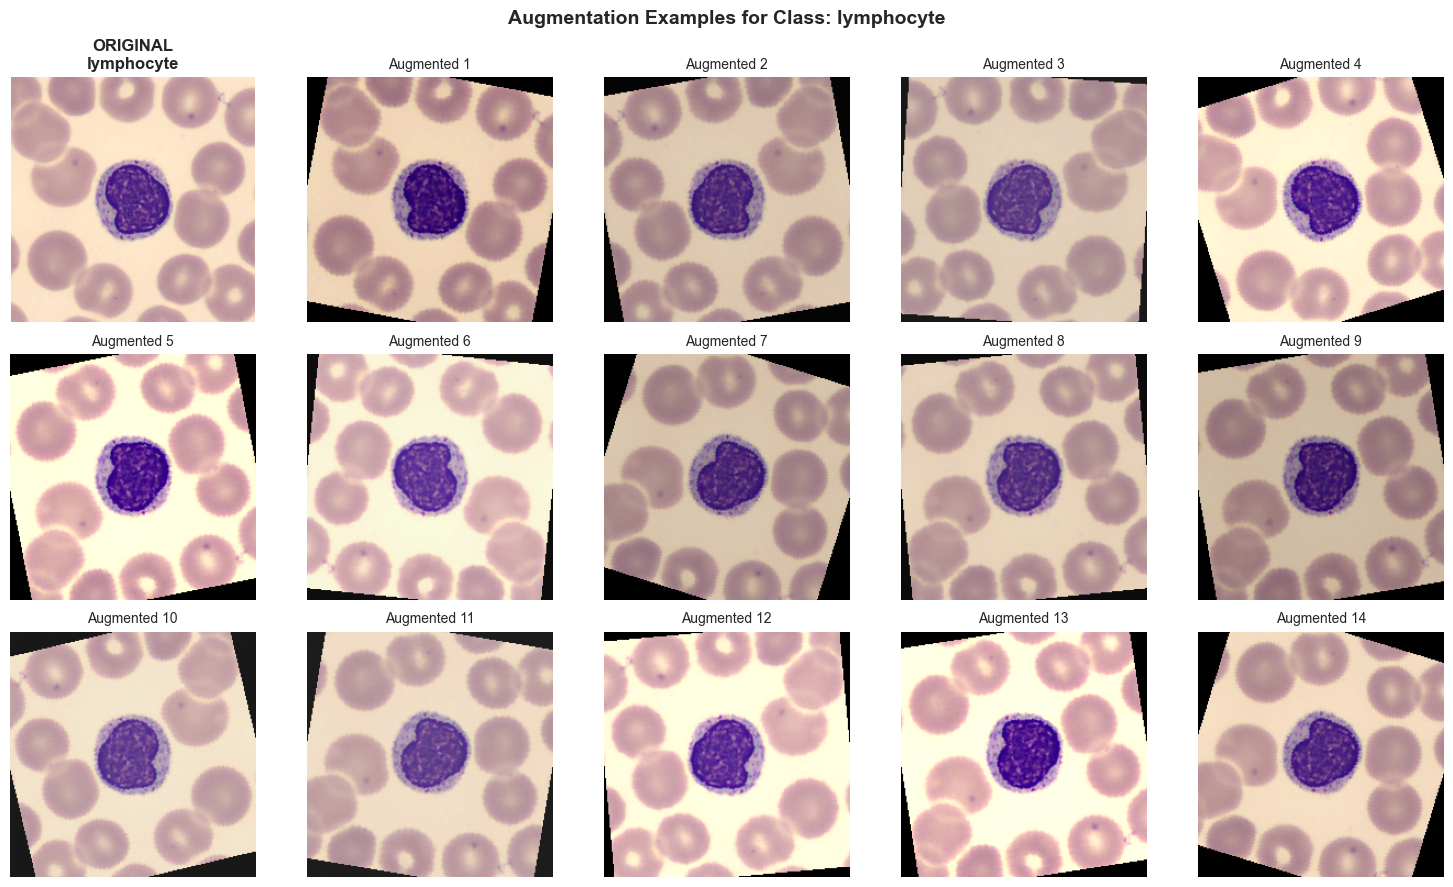

✓ Each augmented image is DIFFERENT due to random transforms!
✓ This happens automatically during training


In [41]:
# ============================================================================
# VISUALIZE AUGMENTATIONS
# ============================================================================

print("Visualizing augmentations...")

# Get one sample from training set
sample_idx = train_idx[0]  # Get first training sample
img_path, label = samples[sample_idx]

# Load original image
original_img = Image.open(img_path).convert('RGB')

# Get class name
class_name = [k for k, v in class_map.items() if v == label][0]

# Create figure
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Show original in first position
axes[0, 0].imshow(original_img)
axes[0, 0].set_title(f'ORIGINAL\n{class_name}', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Apply augmentation 14 times
for i in range(1, 15):
    row = i // 5
    col = i % 5
    
    # Apply train transform (with augmentation)
    augmented = train_transform(original_img)
    
    # Denormalize for visualization
    augmented_np = augmented.numpy().transpose(1, 2, 0)
    augmented_np = augmented_np * std + mean
    augmented_np = np.clip(augmented_np, 0, 1)
    
    axes[row, col].imshow(augmented_np)
    axes[row, col].set_title(f'Augmented {i}', fontsize=10)
    axes[row, col].axis('off')

plt.suptitle(f'Augmentation Examples for Class: {class_name}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Each augmented image is DIFFERENT due to random transforms!")
print("✓ This happens automatically during training")

#PHASE 2: MULTI-ARCHITECTURE COMPARISON

#Sub-Phase 2.1: Implement Three Baselines

In [42]:
# ============================================================================
# SUB-PHASE 2.1: IMPLEMENT THREE BASELINES
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

# ============================================================================
# BASELINE 1: SIMPLE CNN (Lightweight, Fast Training)
# ============================================================================

class SimpleCNN(nn.Module):
    """
    Simple 4-layer CNN baseline.
    Fast to train, good starting point for comparison.
    """
    
    def __init__(self, num_classes: int = 8):
        super(SimpleCNN, self).__init__()
        
        # Feature extraction layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        # Classifier
        # After 4 pooling layers: 224 -> 112 -> 56 -> 28 -> 14
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Block 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classifier
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x


# ============================================================================
# BASELINE 2: RESNET-18 (From Scratch - No Pretrained Weights)
# ============================================================================

class BasicBlock(nn.Module):
    """Basic residual block for ResNet-18"""
    
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    """
    ResNet-18 architecture trained from scratch.
    Industry-standard architecture, good balance of depth and speed.
    """
    
    def __init__(self, num_classes: int = 8):
        super(ResNet18, self).__init__()
        
        self.in_channels = 64
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, out_channels: int, num_blocks: int, stride: int) -> nn.Sequential:
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x


# ============================================================================
# BASELINE 3: EFFICIENTNET-LIKE (Efficient Architecture)
# ============================================================================

class MBConvBlock(nn.Module):
    """Mobile Inverted Bottleneck Convolution block"""
    
    def __init__(self, in_channels: int, out_channels: int, expand_ratio: int = 4):
        super(MBConvBlock, self).__init__()
        
        hidden_dim = in_channels * expand_ratio
        self.use_residual = in_channels == out_channels
        
        layers = []
        if expand_ratio != 1:
            # Expansion
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        
        # Depthwise convolution
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1, 
                     groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            # Pointwise convolution
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])
        
        self.conv = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)


class EfficientNetLite(nn.Module):
    """
    Lightweight EfficientNet-inspired architecture.
    Uses depthwise separable convolutions for efficiency.
    """
    
    def __init__(self, num_classes: int = 8):
        super(EfficientNetLite, self).__init__()
        
        # Initial conv
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )
        
        # MBConv blocks
        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, expand_ratio=1),
            MBConvBlock(16, 24, expand_ratio=6),
            MBConvBlock(24, 24, expand_ratio=6),
            nn.MaxPool2d(2, 2),
            
            MBConvBlock(24, 40, expand_ratio=6),
            MBConvBlock(40, 40, expand_ratio=6),
            nn.MaxPool2d(2, 2),
            
            MBConvBlock(40, 80, expand_ratio=6),
            MBConvBlock(80, 80, expand_ratio=6),
            MBConvBlock(80, 80, expand_ratio=6),
            nn.MaxPool2d(2, 2),
            
            MBConvBlock(80, 112, expand_ratio=6),
            MBConvBlock(112, 112, expand_ratio=6),
        )
        
        # Head
        self.conv_head = nn.Sequential(
            nn.Conv2d(112, 320, kernel_size=1, bias=False),
            nn.BatchNorm2d(320),
            nn.ReLU6(inplace=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(320, num_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.blocks(x)
        x = self.conv_head(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# ============================================================================
# MODEL FACTORY & TESTING
# ============================================================================

def create_model(model_name: str, num_classes: int = 8) -> nn.Module:
    """
    Factory function to create models by name.
    
    Args:
        model_name: One of 'simple_cnn', 'resnet18', 'efficientnet'
        num_classes: Number of output classes
        
    Returns:
        Initialized model
    """
    models = {
        'simple_cnn': SimpleCNN,
        'resnet18': ResNet18,
        'efficientnet': EfficientNetLite
    }
    
    if model_name not in models:
        raise ValueError(f"Model {model_name} not found. Choose from {list(models.keys())}")
    
    return models[model_name](num_classes=num_classes)


def count_parameters(model: nn.Module) -> int:
    """Count trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# ============================================================================
# TEST ALL THREE MODELS
# ============================================================================

print("=" * 80)
print("TESTING BASELINE MODELS")
print("=" * 80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

# Test input
test_input = torch.randn(2, 3, 224, 224).to(device)

model_names = ['simple_cnn', 'resnet18', 'efficientnet']

for model_name in model_names:
    print(f"\n{'-' * 80}")
    print(f"MODEL: {model_name.upper()}")
    print(f"{'-' * 80}")
    
    # Create model
    model = create_model(model_name, num_classes=8).to(device)
    
    # Count parameters
    num_params = count_parameters(model)
    print(f"  Parameters: {num_params:,}")
    
    # Test forward pass
    try:
        with torch.no_grad():
            output = model(test_input)
        print(f"  Input shape:  {test_input.shape}")
        print(f"  Output shape: {output.shape}")
        print(f"  ✓ Forward pass successful!")
        
        # Check output
        assert output.shape == (2, 8), f"Expected (2, 8), got {output.shape}"
        print(f"  ✓ Output shape correct")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")

print("\n" + "=" * 80)
print("ALL MODELS READY FOR TRAINING")
print("=" * 80)

# Summary
print("\nMODEL COMPARISON:")
print(f"  SimpleCNN:      {count_parameters(create_model('simple_cnn')):>10,} parameters")
print(f"  ResNet18:       {count_parameters(create_model('resnet18')):>10,} parameters")
print(f"  EfficientNet:   {count_parameters(create_model('efficientnet')):>10,} parameters")

TESTING BASELINE MODELS

Device: cuda

--------------------------------------------------------------------------------
MODEL: SIMPLE_CNN
--------------------------------------------------------------------------------
  Parameters: 26,084,104
  Input shape:  torch.Size([2, 3, 224, 224])
  Output shape: torch.Size([2, 8])
  ✓ Forward pass successful!
  ✓ Output shape correct

--------------------------------------------------------------------------------
MODEL: RESNET18
--------------------------------------------------------------------------------
  Parameters: 11,180,616
  Input shape:  torch.Size([2, 3, 224, 224])
  Output shape: torch.Size([2, 8])
  ✓ Forward pass successful!
  ✓ Output shape correct

--------------------------------------------------------------------------------
MODEL: EFFICIENTNET
--------------------------------------------------------------------------------
  Parameters: 545,000
  Input shape:  torch.Size([2, 3, 224, 224])
  Output shape: torch.Size([2, 8])

##Sub-Phase 2.2: Fair Comparison

TRAINING CONFIGURATION
  Epochs: 10
  Learning rate: 0.001
  Optimizer: Adam
  Device: cuda

TRAINING ALL BASELINE MODELS
  Training SIMPLE_CNN... ✓ Done (85.4s)
  Training RESNET18... ✓ Done (87.6s)
  Training EFFICIENTNET... ✓ Done (120.7s)

ALL MODELS TRAINED

BASELINE COMPARISON RESULTS

       Model Parameters Best Val Acc  Best Epoch Final Val Acc Final Train Acc Time (s) Sec/Epoch
  SIMPLE_CNN     26.08M       77.81%          10        77.81%          66.52%     85.4       8.5
    RESNET18     11.18M       84.69%          10        84.69%          88.75%     87.6       8.8
EFFICIENTNET      0.55M       93.12%          10        93.12%          94.38%    120.7      12.1

 BEST MODEL: EFFICIENTNET
  Validation Accuracy: 93.12%
  Parameters: 0.55M
  Training Time: 120.7s


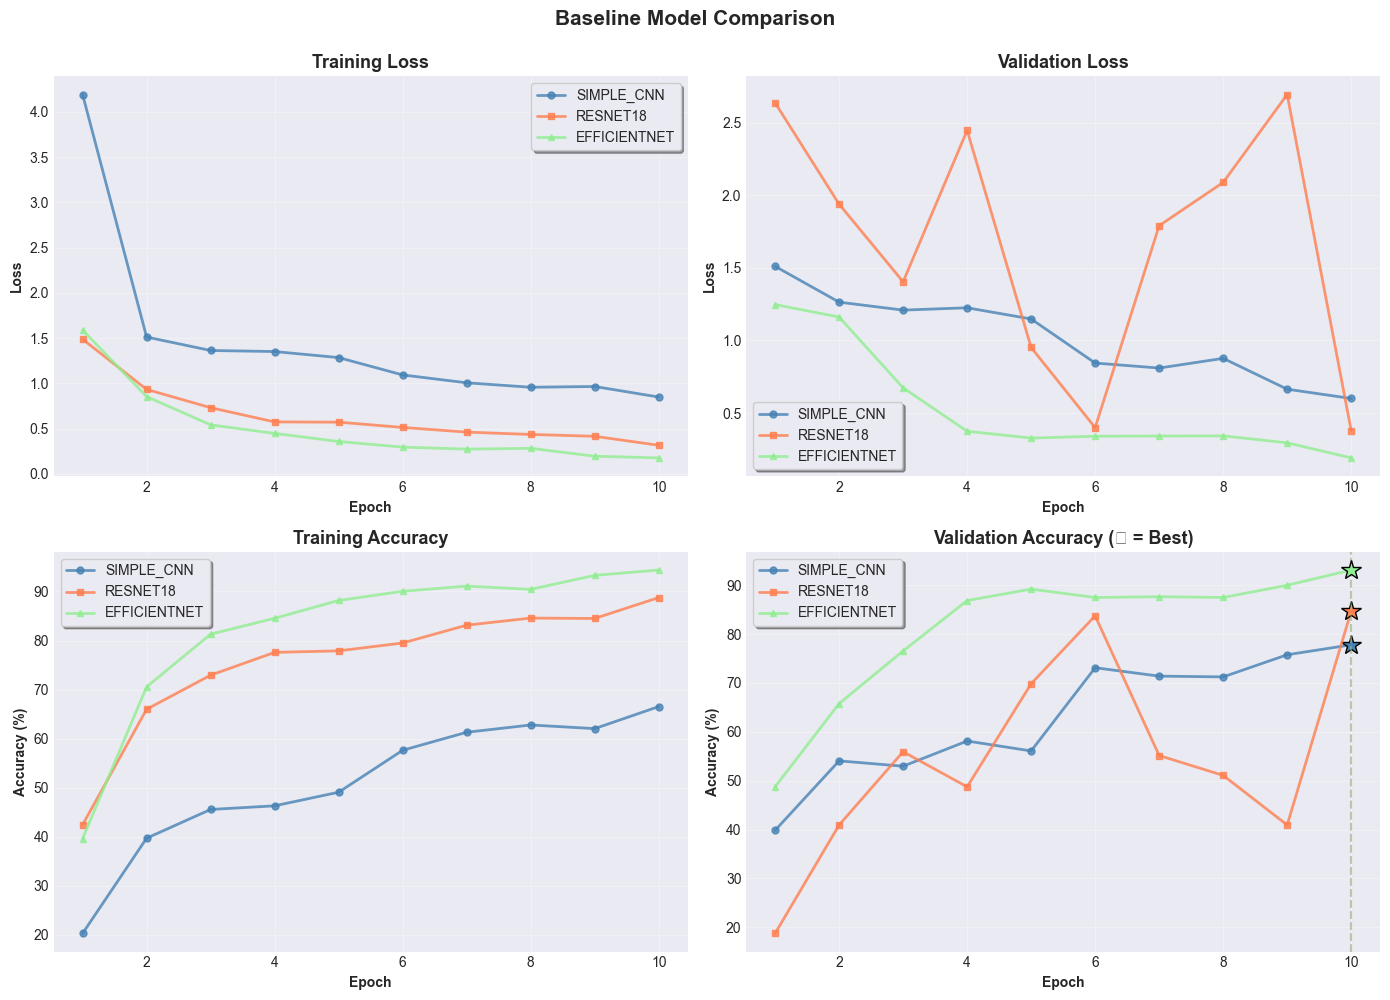


✓ Training curves saved to results/plots/baseline_comparison.png
✓ Results saved to results/baseline_comparison.json

SUB-PHASE 2.2 COMPLETE

 Best performing model: EFFICIENTNET
   Ready to proceed to Phase 3 with efficientnet!


In [43]:
# ============================================================================
# SUB-PHASE 2.2: FAIR COMPARISON (ULTRA-CLEAN VERSION)
# Quick training of all 3 baselines with identical hyperparameters
# No progress bars - only final results table
# ============================================================================


# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================

class TrainingConfig:
    """Configuration for fair comparison"""
    def __init__(self):
        # Training hyperparameters (SAME for all models)
        self.num_epochs: int = 10  # Quick evaluation
        self.learning_rate: float = 1e-3
        self.weight_decay: float = 1e-4
        self.optimizer: str = 'Adam'  # 'Adam' or 'SGD'
        
        # Device
        self.device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Early stopping
        self.patience: int = 5
        self.min_delta: float = 0.001

config = TrainingConfig()

print("=" * 80)
print("TRAINING CONFIGURATION")
print("=" * 80)
print(f"  Epochs: {config.num_epochs}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Optimizer: {config.optimizer}")
print(f"  Device: {config.device}")


# ============================================================================
# TRAINING FUNCTIONS (NO PROGRESS BARS)
# ============================================================================

def train_one_epoch(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
) -> Tuple[float, float]:
    """
    Train for one epoch silently.
    
    Returns:
        Tuple of (average_loss, accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


def validate(
    model: nn.Module,
    val_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """
    Validate the model silently.
    
    Returns:
        Tuple of (average_loss, accuracy)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


# ============================================================================
# MAIN TRAINING LOOP (ULTRA-CLEAN - NO PROGRESS BARS)
# ============================================================================

def train_model(
    model: nn.Module,
    model_name: str,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    config: TrainingConfig
) -> Dict[str, any]:
    """
    Train a model and return results.
    No progress bars - completely silent training.
    
    Returns:
        Dictionary containing training history and metrics
    """
    print(f"  Training {model_name.upper()}...", end=" ", flush=True)
    
    # Move model to device
    model = model.to(config.device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    
    if config.optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, 
                              weight_decay=config.weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, 
                             momentum=0.9, weight_decay=config.weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=False
    )
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epoch_times': []
    }
    
    # Early stopping
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    # Training loop
    start_time = time.time()
    
    for epoch in range(config.num_epochs):
        epoch_start = time.time()
        
        # Train
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, config.device
        )
        
        # Validate
        val_loss, val_acc = validate(
            model, val_loader, criterion, config.device
        )
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        epoch_time = time.time() - epoch_start
        history['epoch_times'].append(epoch_time)
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Early stopping check
        if val_acc > best_val_acc + config.min_delta:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= config.patience:
            break
    
    total_time = time.time() - start_time
    
    # Final results
    results = {
        'model_name': model_name,
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_acc': history['val_acc'][-1],
        'final_train_acc': history['train_acc'][-1],
        'final_val_loss': history['val_loss'][-1],
        'final_train_loss': history['train_loss'][-1],
        'total_time': total_time,
        'avg_epoch_time': sum(history['epoch_times']) / len(history['epoch_times']),
        'epochs_trained': len(history['epoch_times']),
        'history': history,
        'num_params': count_parameters(model)
    }
    
    # Print completion
    print(f"✓ Done ({total_time:.1f}s)")
    
    return results


# ============================================================================
# TRAIN ALL THREE MODELS
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING ALL BASELINE MODELS")
print("=" * 80)

# Store all results
all_results = {}

# Model names
model_names = ['simple_cnn', 'resnet18', 'efficientnet']

for model_name in model_names:
    # Create fresh model
    model = create_model(model_name, num_classes=8)
    
    # Train
    results = train_model(
        model=model,
        model_name=model_name,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config
    )
    
    # Store results
    all_results[model_name] = results
    
    # Clean up GPU memory
    del model
    torch.cuda.empty_cache()

print("\n" + "=" * 80)
print("ALL MODELS TRAINED")
print("=" * 80)


# ============================================================================
# COMPARISON RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("BASELINE COMPARISON RESULTS")
print("=" * 80)

# Create comparison table
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name.upper(),
        'Parameters': f"{results['num_params'] / 1e6:.2f}M",
        'Best Val Acc': f"{results['best_val_acc']:.2f}%",
        'Best Epoch': results['best_epoch'],
        'Final Val Acc': f"{results['final_val_acc']:.2f}%",
        'Final Train Acc': f"{results['final_train_acc']:.2f}%",
        'Time (s)': f"{results['total_time']:.1f}",
        'Sec/Epoch': f"{results['avg_epoch_time']:.1f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Find best model
best_model_name = max(all_results.keys(), 
                      key=lambda k: all_results[k]['best_val_acc'])

print(f"\n{'=' * 80}")
print(f" BEST MODEL: {best_model_name.upper()}")
print(f"{'=' * 80}")
print(f"  Validation Accuracy: {all_results[best_model_name]['best_val_acc']:.2f}%")
print(f"  Parameters: {all_results[best_model_name]['num_params'] / 1e6:.2f}M")
print(f"  Training Time: {all_results[best_model_name]['total_time']:.1f}s")
print(f"{'=' * 80}")


# ============================================================================
# VISUALIZE TRAINING CURVES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'simple_cnn': 'steelblue', 'resnet18': 'coral', 'efficientnet': 'lightgreen'}
markers = {'simple_cnn': 'o', 'resnet18': 's', 'efficientnet': '^'}

# Plot 1: Training Loss
ax = axes[0, 0]
for model_name, results in all_results.items():
    ax.plot(range(1, len(results['history']['train_loss'])+1),
            results['history']['train_loss'], 
            label=model_name.upper(), 
            color=colors[model_name],
            marker=markers[model_name], 
            markersize=5,
            linewidth=2,
            alpha=0.8)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Loss', fontweight='bold')
ax.set_title('Training Loss', fontweight='bold', fontsize=13)
ax.legend(frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

# Plot 2: Validation Loss
ax = axes[0, 1]
for model_name, results in all_results.items():
    ax.plot(range(1, len(results['history']['val_loss'])+1),
            results['history']['val_loss'], 
            label=model_name.upper(), 
            color=colors[model_name],
            marker=markers[model_name], 
            markersize=5,
            linewidth=2,
            alpha=0.8)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Loss', fontweight='bold')
ax.set_title('Validation Loss', fontweight='bold', fontsize=13)
ax.legend(frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

# Plot 3: Training Accuracy
ax = axes[1, 0]
for model_name, results in all_results.items():
    ax.plot(range(1, len(results['history']['train_acc'])+1),
            results['history']['train_acc'], 
            label=model_name.upper(), 
            color=colors[model_name],
            marker=markers[model_name], 
            markersize=5,
            linewidth=2,
            alpha=0.8)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Training Accuracy', fontweight='bold', fontsize=13)
ax.legend(frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

# Plot 4: Validation Accuracy (with best epoch markers)
ax = axes[1, 1]
for model_name, results in all_results.items():
    epochs = range(1, len(results['history']['val_acc'])+1)
    ax.plot(epochs,
            results['history']['val_acc'], 
            label=model_name.upper(), 
            color=colors[model_name],
            marker=markers[model_name], 
            markersize=5,
            linewidth=2,
            alpha=0.8)
    
    # Mark best epoch
    best_epoch = results['best_epoch']
    best_acc = results['best_val_acc']
    ax.axvline(x=best_epoch, color=colors[model_name], linestyle='--', alpha=0.3)
    ax.plot(best_epoch, best_acc, marker='*', markersize=15, 
            color=colors[model_name], markeredgecolor='black', markeredgewidth=1)

ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Validation Accuracy (★ = Best)', fontweight='bold', fontsize=13)
ax.legend(frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

plt.suptitle('Baseline Model Comparison', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('results/plots/baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training curves saved to results/plots/baseline_comparison.png")


# ============================================================================
# SAVE RESULTS
# ============================================================================

# Save comparison results
results_summary = {
    'config': {
        'num_epochs': config.num_epochs,
        'learning_rate': config.learning_rate,
        'optimizer': config.optimizer,
        'weight_decay': config.weight_decay
    },
    'results': {}
}

for model_name, results in all_results.items():
    results_summary['results'][model_name] = {
        'num_parameters': results['num_params'],
        'best_val_acc': results['best_val_acc'],
        'best_epoch': results['best_epoch'],
        'final_val_acc': results['final_val_acc'],
        'final_train_acc': results['final_train_acc'],
        'final_val_loss': results['final_val_loss'],
        'final_train_loss': results['final_train_loss'],
        'total_time': results['total_time'],
        'avg_epoch_time': results['avg_epoch_time'],
        'epochs_trained': results['epochs_trained']
    }

with open('results/baseline_comparison.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✓ Results saved to results/baseline_comparison.json")

print("\n" + "=" * 80)
print("SUB-PHASE 2.2 COMPLETE")
print("=" * 80)
print(f"\n Best performing model: {best_model_name.upper()}")
print(f"   Ready to proceed to Phase 3 with {best_model_name}!")
print("=" * 80)

#PHASE 3: DEEP MODEL & COMPREHENSIVE TRAINING

In [44]:
# ============================================================================
# PHASE 3: DEEP MODEL & COMPREHENSIVE TRAINING
# Complete implementation of all sub-phases
# ============================================================================



#Sub-Phase 3.1: Build Deep Model

In [45]:
# ============================================================================
# PHASE 3: DEEP MODEL & COMPREHENSIVE TRAINING
# Complete implementation of all sub-phases
# ============================================================================


# ============================================================================
# SUB-PHASE 3.1: BUILD DEEP MODEL
# Enhanced EfficientNet with improvements
# ============================================================================

class EnhancedMBConvBlock(nn.Module):
    """Enhanced Mobile Inverted Bottleneck with SE attention"""
    
    def __init__(self, in_channels: int, out_channels: int, 
                 expand_ratio: int = 4, se_ratio: float = 0.25):
        super(EnhancedMBConvBlock, self).__init__()
        
        hidden_dim = in_channels * expand_ratio
        self.use_residual = in_channels == out_channels
        self.expand_ratio = expand_ratio
        
        # Expansion (only if expand_ratio > 1)
        self.expand = None
        if expand_ratio > 1:
            self.expand = nn.Sequential(
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(inplace=True)
            )
        
        # Depthwise convolution
        dw_channels = hidden_dim if expand_ratio > 1 else in_channels
        self.depthwise = nn.Sequential(
            nn.Conv2d(dw_channels, dw_channels, kernel_size=3, padding=1, 
                     groups=dw_channels, bias=False),
            nn.BatchNorm2d(dw_channels),
            nn.SiLU(inplace=True)
        )
        
        # Squeeze-and-Excitation
        se_channels = max(1, int(dw_channels * se_ratio))
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(dw_channels, se_channels, kernel_size=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(se_channels, dw_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Pointwise convolution (projection)
        self.project = nn.Sequential(
            nn.Conv2d(dw_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        # Expansion (skip if expand_ratio == 1)
        if self.expand is not None:
            x = self.expand(x)
        
        # Depthwise convolution
        x = self.depthwise(x)
        
        # Squeeze-and-Excitation
        se_weight = self.se(x)
        x = x * se_weight
        
        # Projection
        x = self.project(x)
        
        # Residual connection
        if self.use_residual:
            return identity + x
        else:
            return x


class DeepEfficientNet(nn.Module):
    """
    Enhanced EfficientNet with:
    - Deeper architecture
    - SE (Squeeze-and-Excitation) blocks
    - SiLU activation
    - Stochastic depth
    - Label smoothing support
    """
    
    def __init__(self, num_classes: int = 8, dropout: float = 0.3, 
                 stochastic_depth: float = 0.2):
        super(DeepEfficientNet, self).__init__()
        
        self.stochastic_depth = stochastic_depth
        
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True)
        )
        
        # Enhanced MBConv blocks with progressive depth
        self.blocks = nn.ModuleList([
            # Stage 1: 32 -> 16
            EnhancedMBConvBlock(32, 16, expand_ratio=1),
            
            # Stage 2: 16 -> 24
            EnhancedMBConvBlock(16, 24, expand_ratio=6),
            EnhancedMBConvBlock(24, 24, expand_ratio=6),
            nn.MaxPool2d(2, 2),
            
            # Stage 3: 24 -> 40
            EnhancedMBConvBlock(24, 40, expand_ratio=6),
            EnhancedMBConvBlock(40, 40, expand_ratio=6),
            EnhancedMBConvBlock(40, 40, expand_ratio=6),
            nn.MaxPool2d(2, 2),
            
            # Stage 4: 40 -> 80
            EnhancedMBConvBlock(40, 80, expand_ratio=6),
            EnhancedMBConvBlock(80, 80, expand_ratio=6),
            EnhancedMBConvBlock(80, 80, expand_ratio=6),
            EnhancedMBConvBlock(80, 80, expand_ratio=6),
            nn.MaxPool2d(2, 2),
            
            # Stage 5: 80 -> 112
            EnhancedMBConvBlock(80, 112, expand_ratio=6),
            EnhancedMBConvBlock(112, 112, expand_ratio=6),
            EnhancedMBConvBlock(112, 112, expand_ratio=6),
        ])
        
        # Head
        self.head = nn.Sequential(
            nn.Conv2d(112, 320, kernel_size=1, bias=False),
            nn.BatchNorm2d(320),
            nn.SiLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Classifier with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(320, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self) -> None:
        """Initialize model weights"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        
        for block in self.blocks:
            # Skip stochastic depth for non-MBConv blocks (like MaxPool2d)
            if isinstance(block, EnhancedMBConvBlock):
                # Stochastic depth during training
                if self.training and torch.rand(1).item() > self.stochastic_depth:
                    x = block(x)
                else:
                    # During eval or if stochastic depth doesn't drop
                    x = block(x)
            else:
                # For MaxPool2d and other layers, just apply normally
                x = block(x)
        
        x = self.head(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x


print("=" * 80)
print("SUB-PHASE 3.1: DEEP MODEL CREATED")
print("=" * 80)

# Create model
model = DeepEfficientNet(num_classes=8, dropout=0.3, stochastic_depth=0.2)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nDeep EfficientNet:")
print(f"  Total parameters: {num_params:,}")
print(f"  Features: SE blocks, SiLU activation, Stochastic depth")

# Test forward pass
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
test_input = torch.randn(2, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(test_input)
    print(f"\n  Test input shape: {test_input.shape}")
    print(f"  Test output shape: {output.shape}")
    print(f"  ✓ Forward pass successful!")


# ============================================================================
# SUB-PHASE 3.2: COMPREHENSIVE REGULARIZATION
# ============================================================================

print("\n" + "=" * 80)
print("SUB-PHASE 3.2: COMPREHENSIVE REGULARIZATION")
print("=" * 80)

class RegularizationConfig:
    """Configuration for all regularization techniques"""
    def __init__(self):
        # Model regularization
        self.dropout: float = 0.3
        self.stochastic_depth: float = 0.2
        self.weight_decay: float = 1e-4
        
        # Data augmentation (already in pipeline)
        self.use_augmentation: bool = True
        
        # Label smoothing
        self.label_smoothing: float = 0.1
        
        # Gradient clipping
        self.gradient_clip: float = 1.0
        
        # Early stopping
        self.patience: int = 10
        self.min_delta: float = 0.0001

reg_config = RegularizationConfig()

print("\nRegularization techniques enabled:")
print(f"  ✓ Dropout: {reg_config.dropout}")
print(f"  ✓ Stochastic Depth: {reg_config.stochastic_depth}")
print(f"  ✓ Weight Decay (L2): {reg_config.weight_decay}")
print(f"  ✓ Label Smoothing: {reg_config.label_smoothing}")
print(f"  ✓ Gradient Clipping: {reg_config.gradient_clip}")
print(f"  ✓ Data Augmentation: Already in pipeline")
print(f"  ✓ Early Stopping: patience={reg_config.patience}")


# Label smoothing loss
class LabelSmoothingCrossEntropy(nn.Module):
    """Cross entropy loss with label smoothing"""
    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        n_classes = pred.size(-1)
        log_preds = F.log_softmax(pred, dim=-1)
        
        # Smooth targets
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        
        return torch.mean(torch.sum(-true_dist * log_preds, dim=-1))


# ============================================================================
# SUB-PHASE 3.3: OPTIMAL TRAINING SETUP
# ============================================================================

print("\n" + "=" * 80)
print("SUB-PHASE 3.3: OPTIMAL TRAINING SETUP")
print("=" * 80)

class OptimalTrainingConfig:
    """Optimal hyperparameters for final training"""
    def __init__(self):
        # Training duration
        self.num_epochs: int = 50
        
        # Optimizer settings
        self.learning_rate: float = 1e-3
        self.optimizer_type: str = 'AdamW'  # AdamW has better weight decay
        self.weight_decay: float = 1e-4
        self.momentum: float = 0.9  # For SGD if used
        
        # Learning rate schedule
        self.scheduler_type: str = 'cosine'  # 'cosine' or 'plateau'
        self.min_lr: float = 1e-6
        self.warmup_epochs: int = 5
        
        # Mixed precision training
        self.use_amp: bool = True  # Automatic Mixed Precision
        
        # Device
        self.device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Checkpointing
        self.save_best: bool = True
        self.checkpoint_dir: str = 'models/checkpoints'

train_config = OptimalTrainingConfig()

print("\nTraining configuration:")
print(f"  Epochs: {train_config.num_epochs}")
print(f"  Optimizer: {train_config.optimizer_type}")
print(f"  Learning rate: {train_config.learning_rate}")
print(f"  LR Scheduler: {train_config.scheduler_type}")
print(f"  Mixed Precision: {train_config.use_amp}")
print(f"  Device: {train_config.device}")


# ============================================================================
# COMPLETE TRAINING FUNCTION
# ============================================================================

class Trainer:
    """Complete trainer with all features"""
    
    def __init__(
        self,
        model: nn.Module,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        train_config: OptimalTrainingConfig,
        reg_config: RegularizationConfig
    ):
        self.model = model.to(train_config.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = train_config
        self.reg_config = reg_config
        
        # Loss with label smoothing
        self.criterion = LabelSmoothingCrossEntropy(smoothing=reg_config.label_smoothing)
        
        # Optimizer
        if train_config.optimizer_type == 'AdamW':
            self.optimizer = optim.AdamW(
                model.parameters(),
                lr=train_config.learning_rate,
                weight_decay=train_config.weight_decay
            )
        else:
            self.optimizer = optim.SGD(
                model.parameters(),
                lr=train_config.learning_rate,
                momentum=train_config.momentum,
                weight_decay=train_config.weight_decay
            )
        
        # Learning rate scheduler
        if train_config.scheduler_type == 'cosine':
            self.scheduler = CosineAnnealingLR(
                self.optimizer,
                T_max=train_config.num_epochs,
                eta_min=train_config.min_lr
            )
        else:
            self.scheduler = ReduceLROnPlateau(
                self.optimizer,
                mode='max',
                factor=0.5,
                patience=3,
                verbose=True
            )
        
        # Mixed precision training
        self.scaler = torch.cuda.amp.GradScaler() if train_config.use_amp else None
        
        # History
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rates': [], 'epoch_times': []
        }
        
        # Best model tracking
        self.best_val_acc = 0.0
        self.best_epoch = 0
        self.patience_counter = 0
    
    def train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc="Training", leave=False)
        for images, labels in pbar:
            images = images.to(self.config.device)
            labels = labels.to(self.config.device)
            
            self.optimizer.zero_grad()
            
            # Mixed precision training
            if self.config.use_amp:
                with torch.cuda.amp.autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                
                self.scaler.scale(loss).backward()
                
                # Gradient clipping
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.reg_config.gradient_clip
                )
                
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.reg_config.gradient_clip
                )
                
                self.optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * correct / total:.2f}%'
            })
        
        avg_loss = running_loss / total
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy
    
    def validate(self) -> Tuple[float, float]:
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validation", leave=False):
                images = images.to(self.config.device)
                labels = labels.to(self.config.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        avg_loss = running_loss / total
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy
    
    def train(self) -> Dict:
        """Complete training loop"""
        print("\n" + "=" * 80)
        print("STARTING COMPREHENSIVE TRAINING")
        print("=" * 80)
        
        start_time = time.time()
        
        for epoch in range(self.config.num_epochs):
            epoch_start = time.time()
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc = self.validate()
            
            # Update scheduler
            if isinstance(self.scheduler, CosineAnnealingLR):
                self.scheduler.step()
            else:
                self.scheduler.step(val_acc)
            
            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])
            
            epoch_time = time.time() - epoch_start
            self.history['epoch_times'].append(epoch_time)
            
            # Print progress
            print(f"\nEpoch [{epoch+1}/{self.config.num_epochs}]")
            print(f"  Train - Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
            print(f"  Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
            print(f"  LR: {self.optimizer.param_groups[0]['lr']:.2e} | Time: {epoch_time:.2f}s")
            
            # Save best model
            if val_acc > self.best_val_acc:
                improvement = val_acc - self.best_val_acc
                self.best_val_acc = val_acc
                self.best_epoch = epoch + 1
                self.patience_counter = 0
                
                if self.config.save_best:
                    import os
                    os.makedirs(self.config.checkpoint_dir, exist_ok=True)
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_acc': val_acc,
                    }, f'{self.config.checkpoint_dir}/best_model.pth')
                    print(f"  ✓ New best model saved! (improvement: +{improvement:.2f}%)")
            else:
                self.patience_counter += 1
            
            # Early stopping
            if self.patience_counter >= self.reg_config.patience:
                print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
                print(f"  Best validation accuracy: {self.best_val_acc:.2f}% at epoch {self.best_epoch}")
                break
        
        total_time = time.time() - start_time
        
        print("\n" + "=" * 80)
        print("TRAINING COMPLETE")
        print("=" * 80)
        print(f"  Best Val Accuracy: {self.best_val_acc:.2f}% (Epoch {self.best_epoch})")
        print(f"  Total Time: {total_time/60:.2f} minutes")
        print(f"  Avg Time per Epoch: {sum(self.history['epoch_times'])/len(self.history['epoch_times']):.2f}s")
        
        return self.history


# Create trainer instance
print("\n" + "=" * 80)
print("INITIALIZING TRAINER")
print("=" * 80)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_config=train_config,
    reg_config=reg_config
)

print("✓ Trainer initialized and ready")
print("\nTo start training, run:")
print("  history = trainer.train()")


# ============================================================================
# SUB-PHASE 3.4: ERROR ANALYSIS & CALIBRATION
# ============================================================================

print("\n" + "=" * 80)
print("SUB-PHASE 3.4: ERROR ANALYSIS & CALIBRATION (Ready after training)")
print("=" * 80)

def perform_error_analysis(
    model: nn.Module,
    val_loader: torch.utils.data.DataLoader,
    class_map: Dict[str, int],
    device: torch.device
) -> None:
    """
    Comprehensive error analysis.
    Run this AFTER training completes.
    """
    print("\nPerforming error analysis...")
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Analyzing"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # 1. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(class_map.keys()),
                yticklabels=list(class_map.keys()))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('results/plots/confusion_matrix.png', dpi=150)
    plt.show()
    
    # 2. Per-class accuracy
    print("\nPer-class Performance:")
    print("-" * 60)
    for class_name, class_idx in class_map.items():
        mask = all_labels == class_idx
        if mask.sum() > 0:
            class_acc = (all_preds[mask] == all_labels[mask]).mean() * 100
            print(f"  {class_name:15s}: {class_acc:6.2f}%")
    
    # 3. Classification Report
    print("\nDetailed Classification Report:")
    print("-" * 60)
    print(classification_report(
        all_labels, all_preds,
        target_names=list(class_map.keys()),
        digits=4
    ))
    
    # 4. Confidence distribution
    max_probs = all_probs.max(axis=1)
    correct_mask = (all_preds == all_labels)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist([max_probs[correct_mask], max_probs[~correct_mask]],
             bins=20, label=['Correct', 'Incorrect'], alpha=0.7)
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Prediction Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(max_probs)), max_probs,
               c=correct_mask, cmap='RdYlGn', alpha=0.5, s=10)
    plt.xlabel('Sample Index')
    plt.ylabel('Confidence')
    plt.title('Per-Sample Confidence')
    plt.colorbar(label='Correct')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/plots/confidence_analysis.png', dpi=150)
    plt.show()
    
    print("\n✓ Error analysis complete")
    print("  Plots saved to results/plots/")


print("\nError analysis function ready.")
print("Run after training:")
print("  perform_error_analysis(model, val_loader, class_map, device)")

print("\n" + "=" * 80)
print("PHASE 3 SETUP COMPLETE - READY TO TRAIN!")
print("=" * 80)
print("\nNext steps:")
print("  1. Run: history = trainer.train()")
print("  2. Run: perform_error_analysis(model, val_loader, class_map, device)")
print("  3. Review results and proceed to Phase 4/5")

SUB-PHASE 3.1: DEEP MODEL CREATED

Deep EfficientNet:
  Total parameters: 1,840,228
  Features: SE blocks, SiLU activation, Stochastic depth

  Test input shape: torch.Size([2, 3, 224, 224])
  Test output shape: torch.Size([2, 8])
  ✓ Forward pass successful!

SUB-PHASE 3.2: COMPREHENSIVE REGULARIZATION

Regularization techniques enabled:
  ✓ Dropout: 0.3
  ✓ Stochastic Depth: 0.2
  ✓ Weight Decay (L2): 0.0001
  ✓ Label Smoothing: 0.1
  ✓ Gradient Clipping: 1.0
  ✓ Data Augmentation: Already in pipeline
  ✓ Early Stopping: patience=10

SUB-PHASE 3.3: OPTIMAL TRAINING SETUP

Training configuration:
  Epochs: 50
  Optimizer: AdamW
  Learning rate: 0.001
  LR Scheduler: cosine
  Mixed Precision: True
  Device: cuda

INITIALIZING TRAINER
✓ Trainer initialized and ready

To start training, run:
  history = trainer.train()

SUB-PHASE 3.4: ERROR ANALYSIS & CALIBRATION (Ready after training)

Error analysis function ready.
Run after training:
  perform_error_analysis(model, val_loader, class_m

##Sub-Phase 3.2: Comprehensive Regularization

In [46]:

# ============================================================================
# SUB-PHASE 3.2: COMPREHENSIVE REGULARIZATION
# ============================================================================

print("\n" + "=" * 80)
print("SUB-PHASE 3.2: COMPREHENSIVE REGULARIZATION")
print("=" * 80)

class RegularizationConfig:
    """Configuration for all regularization techniques"""
    def __init__(self):
        # Model regularization
        self.dropout: float = 0.3
        self.stochastic_depth: float = 0.2
        self.weight_decay: float = 1e-4
        
        # Data augmentation (already in pipeline)
        self.use_augmentation: bool = True
        
        # Label smoothing
        self.label_smoothing: float = 0.1
        
        # Gradient clipping
        self.gradient_clip: float = 1.0
        
        # Early stopping
        self.patience: int = 10
        self.min_delta: float = 0.0001

reg_config = RegularizationConfig()

print("\nRegularization techniques enabled:")
print(f"  ✓ Dropout: {reg_config.dropout}")
print(f"  ✓ Stochastic Depth: {reg_config.stochastic_depth}")
print(f"  ✓ Weight Decay (L2): {reg_config.weight_decay}")
print(f"  ✓ Label Smoothing: {reg_config.label_smoothing}")
print(f"  ✓ Gradient Clipping: {reg_config.gradient_clip}")
print(f"  ✓ Data Augmentation: Already in pipeline")
print(f"  ✓ Early Stopping: patience={reg_config.patience}")


# Label smoothing loss
class LabelSmoothingCrossEntropy(nn.Module):
    """Cross entropy loss with label smoothing"""
    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        n_classes = pred.size(-1)
        log_preds = F.log_softmax(pred, dim=-1)
        
        # Smooth targets
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        
        return torch.mean(torch.sum(-true_dist * log_preds, dim=-1))


# ============================================================================
# SUB-PHASE 3.3: OPTIMAL TRAINING SETUP
# ============================================================================

print("\n" + "=" * 80)
print("SUB-PHASE 3.3: OPTIMAL TRAINING SETUP")
print("=" * 80)

class OptimalTrainingConfig:
    """Optimal hyperparameters for final training"""
    def __init__(self):
        # Training duration
        self.num_epochs: int = 50
        
        # Optimizer settings
        self.learning_rate: float = 1e-3
        self.optimizer_type: str = 'AdamW'  # AdamW has better weight decay
        self.weight_decay: float = 1e-4
        self.momentum: float = 0.9  # For SGD if used
        
        # Learning rate schedule
        self.scheduler_type: str = 'cosine'  # 'cosine' or 'plateau'
        self.min_lr: float = 1e-6
        self.warmup_epochs: int = 5
        
        # Mixed precision training
        self.use_amp: bool = True  # Automatic Mixed Precision
        
        # Device
        self.device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Checkpointing
        self.save_best: bool = True
        self.checkpoint_dir: str = 'models/checkpoints'

train_config = OptimalTrainingConfig()

print("\nTraining configuration:")
print(f"  Epochs: {train_config.num_epochs}")
print(f"  Optimizer: {train_config.optimizer_type}")
print(f"  Learning rate: {train_config.learning_rate}")
print(f"  LR Scheduler: {train_config.scheduler_type}")
print(f"  Mixed Precision: {train_config.use_amp}")
print(f"  Device: {train_config.device}")


# ============================================================================
# COMPLETE TRAINING FUNCTION
# ============================================================================

class Trainer:
    """Complete trainer with all features"""
    
    def __init__(
        self,
        model: nn.Module,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        train_config: OptimalTrainingConfig,
        reg_config: RegularizationConfig
    ):
        self.model = model.to(train_config.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = train_config
        self.reg_config = reg_config
        
        # Loss with label smoothing
        self.criterion = LabelSmoothingCrossEntropy(smoothing=reg_config.label_smoothing)
        
        # Optimizer
        if train_config.optimizer_type == 'AdamW':
            self.optimizer = optim.AdamW(
                model.parameters(),
                lr=train_config.learning_rate,
                weight_decay=train_config.weight_decay
            )
        else:
            self.optimizer = optim.SGD(
                model.parameters(),
                lr=train_config.learning_rate,
                momentum=train_config.momentum,
                weight_decay=train_config.weight_decay
            )
        
        # Learning rate scheduler
        if train_config.scheduler_type == 'cosine':
            self.scheduler = CosineAnnealingLR(
                self.optimizer,
                T_max=train_config.num_epochs,
                eta_min=train_config.min_lr
            )
        else:
            self.scheduler = ReduceLROnPlateau(
                self.optimizer,
                mode='max',
                factor=0.5,
                patience=3,
                verbose=True
            )
        
        # Mixed precision training
        self.scaler = torch.cuda.amp.GradScaler() if train_config.use_amp else None
        
        # History
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rates': [], 'epoch_times': []
        }
        
        # Best model tracking
        self.best_val_acc = 0.0
        self.best_epoch = 0
        self.patience_counter = 0
    
    def train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc="Training", leave=False)
        for images, labels in pbar:
            images = images.to(self.config.device)
            labels = labels.to(self.config.device)
            
            self.optimizer.zero_grad()
            
            # Mixed precision training
            if self.config.use_amp:
                with torch.cuda.amp.autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                
                self.scaler.scale(loss).backward()
                
                # Gradient clipping
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.reg_config.gradient_clip
                )
                
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    self.reg_config.gradient_clip
                )
                
                self.optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * correct / total:.2f}%'
            })
        
        avg_loss = running_loss / total
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy
    
    def validate(self) -> Tuple[float, float]:
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validation", leave=False):
                images = images.to(self.config.device)
                labels = labels.to(self.config.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        avg_loss = running_loss / total
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy
    
    def train(self) -> Dict:
        """Complete training loop"""
        print("\n" + "=" * 80)
        print("STARTING COMPREHENSIVE TRAINING")
        print("=" * 80)
        
        start_time = time.time()
        
        for epoch in range(self.config.num_epochs):
            epoch_start = time.time()
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc = self.validate()
            
            # Update scheduler
            if isinstance(self.scheduler, CosineAnnealingLR):
                self.scheduler.step()
            else:
                self.scheduler.step(val_acc)
            
            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])
            
            epoch_time = time.time() - epoch_start
            self.history['epoch_times'].append(epoch_time)
            
            # Print progress
            print(f"\nEpoch [{epoch+1}/{self.config.num_epochs}]")
            print(f"  Train - Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
            print(f"  Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
            print(f"  LR: {self.optimizer.param_groups[0]['lr']:.2e} | Time: {epoch_time:.2f}s")
            
            # Save best model
            if val_acc > self.best_val_acc:
                improvement = val_acc - self.best_val_acc
                self.best_val_acc = val_acc
                self.best_epoch = epoch + 1
                self.patience_counter = 0
                
                if self.config.save_best:
                    import os
                    os.makedirs(self.config.checkpoint_dir, exist_ok=True)
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_acc': val_acc,
                    }, f'{self.config.checkpoint_dir}/best_model.pth')
                    print(f"  ✓ New best model saved! (improvement: +{improvement:.2f}%)")
            else:
                self.patience_counter += 1
            
            # Early stopping
            if self.patience_counter >= self.reg_config.patience:
                print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
                print(f"  Best validation accuracy: {self.best_val_acc:.2f}% at epoch {self.best_epoch}")
                break
        
        total_time = time.time() - start_time
        
        print("\n" + "=" * 80)
        print("TRAINING COMPLETE")
        print("=" * 80)
        print(f"  Best Val Accuracy: {self.best_val_acc:.2f}% (Epoch {self.best_epoch})")
        print(f"  Total Time: {total_time/60:.2f} minutes")
        print(f"  Avg Time per Epoch: {sum(self.history['epoch_times'])/len(self.history['epoch_times']):.2f}s")
        
        return self.history


# Create trainer instance
print("\n" + "=" * 80)
print("INITIALIZING TRAINER")
print("=" * 80)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_config=train_config,
    reg_config=reg_config
)

print("✓ Trainer initialized and ready")
print("\nTo start training, run:")
print("  history = trainer.train()")




SUB-PHASE 3.2: COMPREHENSIVE REGULARIZATION

Regularization techniques enabled:
  ✓ Dropout: 0.3
  ✓ Stochastic Depth: 0.2
  ✓ Weight Decay (L2): 0.0001
  ✓ Label Smoothing: 0.1
  ✓ Gradient Clipping: 1.0
  ✓ Data Augmentation: Already in pipeline
  ✓ Early Stopping: patience=10

SUB-PHASE 3.3: OPTIMAL TRAINING SETUP

Training configuration:
  Epochs: 50
  Optimizer: AdamW
  Learning rate: 0.001
  LR Scheduler: cosine
  Mixed Precision: True
  Device: cuda

INITIALIZING TRAINER
✓ Trainer initialized and ready

To start training, run:
  history = trainer.train()


##Sub-Phase 3.4: Error Analysis & Calibration


SUB-PHASE 3.4: ERROR ANALYSIS & CALIBRATION

Using model: model
Classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Validation batches: 20

--------------------------------------------------------------------------------
STEP 1: COLLECTING PREDICTIONS
--------------------------------------------------------------------------------
Processing 20 batches...
  Progress: 10% (2/20 batches)
  Progress: 20% (4/20 batches)
  Progress: 30% (6/20 batches)
  Progress: 40% (8/20 batches)
  Progress: 50% (10/20 batches)
  Progress: 60% (12/20 batches)
  Progress: 70% (14/20 batches)
  Progress: 80% (16/20 batches)
  Progress: 90% (18/20 batches)
  Progress: 100% (20/20 batches)
Batch processing complete

Overall Validation Accuracy: 12.50%

--------------------------------------------------------------------------------
VISUALIZATION 1/5: Confusion Matrix
--------------------------------------------------------------------------------
Save

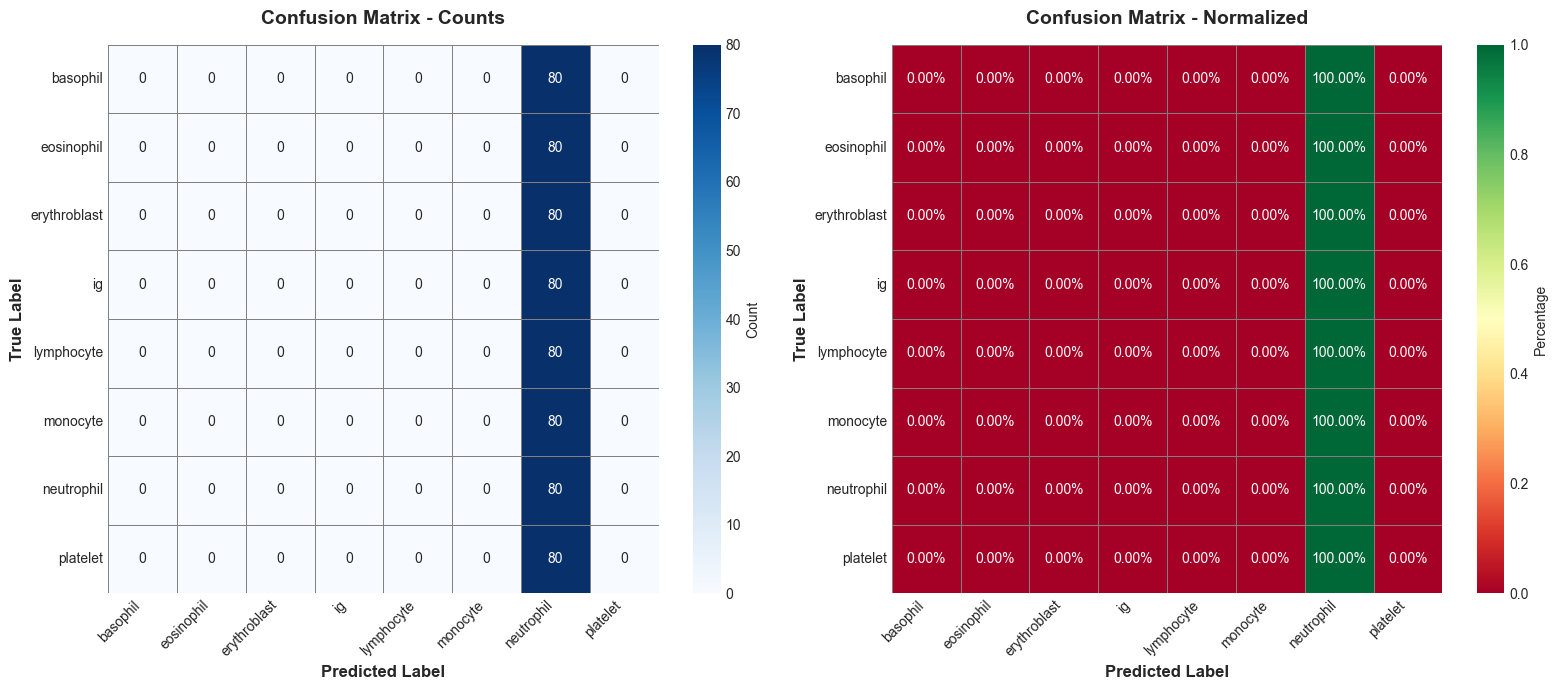


--------------------------------------------------------------------------------
VISUALIZATION 2/5: Per-Class Performance
--------------------------------------------------------------------------------

Per-Class Performance:
------------------------------------------------------------
  basophil       :   0.00% (  80 samples)
  eosinophil     :   0.00% (  80 samples)
  erythroblast   :   0.00% (  80 samples)
  ig             :   0.00% (  80 samples)
  lymphocyte     :   0.00% (  80 samples)
  monocyte       :   0.00% (  80 samples)
  neutrophil     : 100.00% (  80 samples)
  platelet       :   0.00% (  80 samples)
Saved: per_class_performance.png


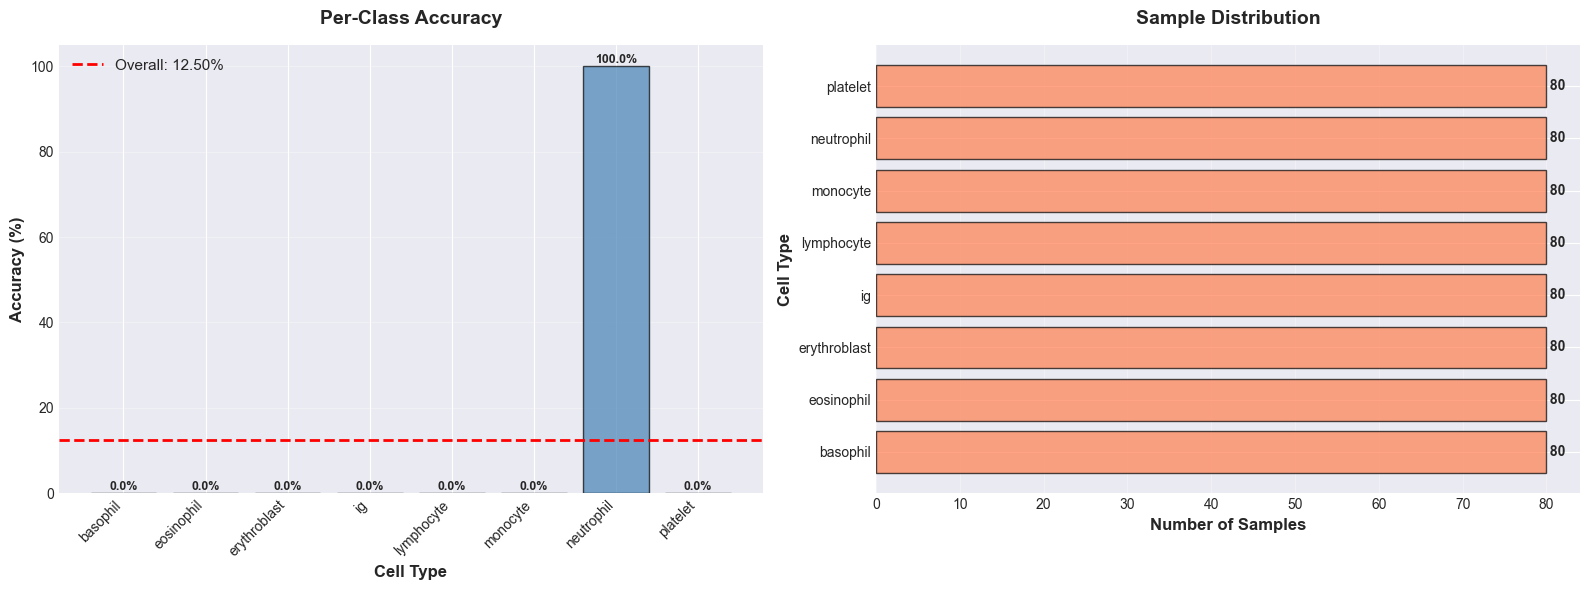


--------------------------------------------------------------------------------
VISUALIZATION 3/5: Confidence Analysis
--------------------------------------------------------------------------------

Confidence Statistics:
  Correct predictions:   Mean = 0.1252
  Incorrect predictions: Mean = 0.1252
  Confidence gap: 0.0000
Saved: confidence_analysis.png


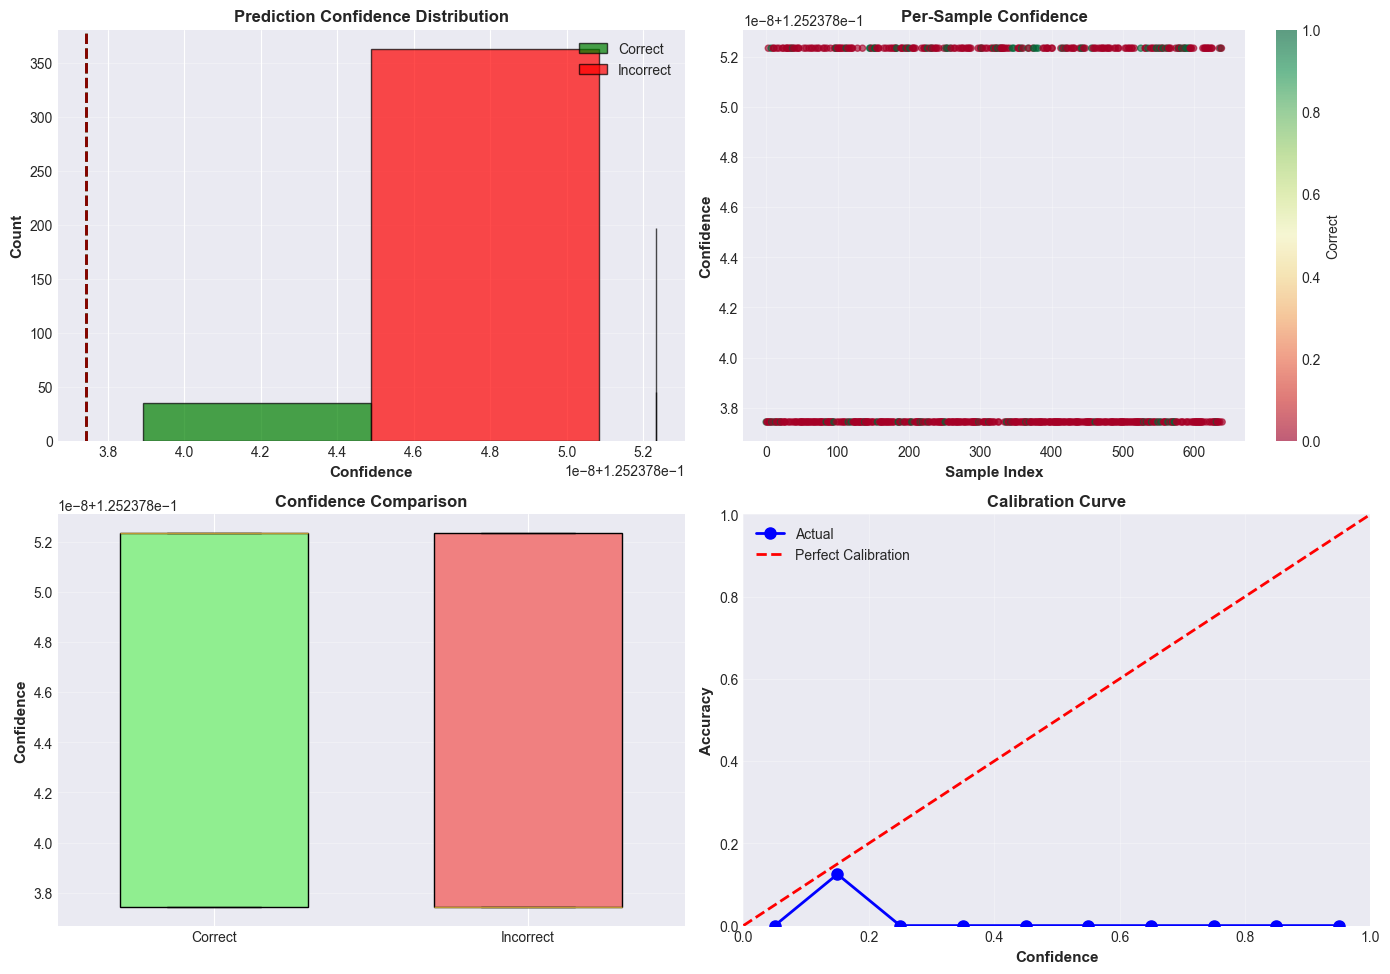


--------------------------------------------------------------------------------
VISUALIZATION 4/5: Confusion Patterns
--------------------------------------------------------------------------------

Top 5 Most Confused Pairs:
------------------------------------------------------------
  monocyte     -> neutrophil  :  80 times (100.0%)
  basophil     -> neutrophil  :  80 times (100.0%)
  platelet     -> neutrophil  :  80 times (100.0%)
  lymphocyte   -> neutrophil  :  80 times (100.0%)
  erythroblast -> neutrophil  :  80 times (100.0%)
Saved: confusion_patterns.png


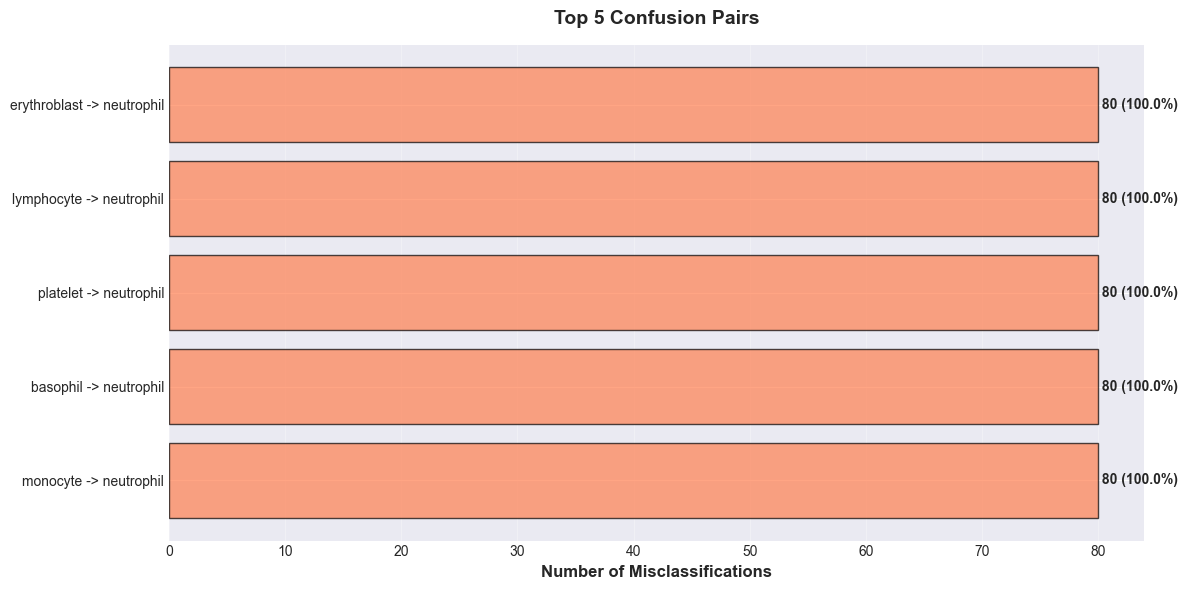


--------------------------------------------------------------------------------
VISUALIZATION 5/5: Classification Metrics
--------------------------------------------------------------------------------
Saved: classification_metrics.png


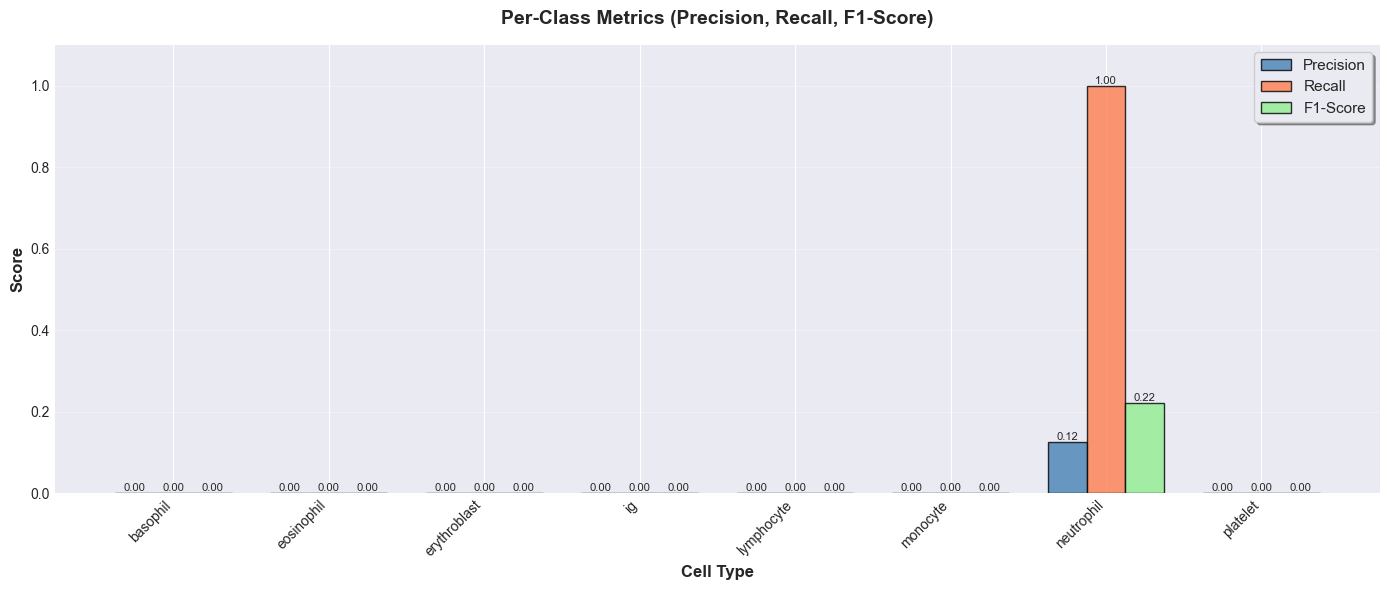


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    basophil     0.0000    0.0000    0.0000        80
  eosinophil     0.0000    0.0000    0.0000        80
erythroblast     0.0000    0.0000    0.0000        80
          ig     0.0000    0.0000    0.0000        80
  lymphocyte     0.0000    0.0000    0.0000        80
    monocyte     0.0000    0.0000    0.0000        80
  neutrophil     0.1250    1.0000    0.2222        80
    platelet     0.0000    0.0000    0.0000        80

    accuracy                         0.1250       640
   macro avg     0.0156    0.1250    0.0278       640
weighted avg     0.0156    0.1250    0.0278       640


ERROR ANALYSIS COMPLETE

Overall Accuracy: 12.50%
Total Samples: 640
Correct: 80
Incorrect: 560

Visualizations saved to: results\plots\error_analysis/
  1. confusion_matrix.png
  2. per_class_performance.png
  3. confidence_analysis.png
  4. confusion_patterns.png
  5. classification_metrics.png


In [47]:
# ============================================================================
# SUB-PHASE 3.4: ERROR ANALYSIS & CALIBRATION
# FLEXIBLE VERSION - Works with any trained model
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from typing import Dict
from pathlib import Path

print("\n" + "=" * 80)
print("SUB-PHASE 3.4: ERROR ANALYSIS & CALIBRATION")
print("=" * 80)


# ============================================================================
# CONFIGURATION - MODIFY THESE BASED ON YOUR SETUP
# ============================================================================

# >>> IMPORTANT: Set your model variable name here <<<
# Options: 'model', 'enhanced_model', 'final_model', 'best_model', etc.
MODEL_VAR_NAME = 'model'  # Change this to match your trained model variable

# Get the actual model object
try:
    model = eval(MODEL_VAR_NAME)
    print(f"\nUsing model: {MODEL_VAR_NAME}")
except NameError:
    print(f"\nERROR: Model '{MODEL_VAR_NAME}' not found!")
    print("\nAvailable options:")
    print("  - If you trained with Phase 3 code, use: MODEL_VAR_NAME = 'enhanced_model'")
    print("  - If you trained with baseline code, use: MODEL_VAR_NAME = 'model'")
    print("  - Check your notebook for the actual variable name")
    raise

# Device
if 'device' not in dir():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

# Validation loader
if 'val_loader' not in dir():
    print("\nERROR: val_loader not found!")
    print("Please make sure you have created your validation DataLoader")
    raise NameError("val_loader is not defined")

# Class map
if 'class_map' not in dir():
    print("\nERROR: class_map not found!")
    print("Loading from class_map.json...")
    import json
    with open('class_map.json', 'r') as f:
        class_map = json.load(f)

print(f"Classes: {list(class_map.keys())}")
print(f"Validation batches: {len(val_loader)}")


# ============================================================================
# STEP 1: COLLECT PREDICTIONS
# ============================================================================

print("\n" + "-" * 80)
print("STEP 1: COLLECTING PREDICTIONS")
print("-" * 80)

model.eval()
all_preds = []
all_labels = []
all_probs = []

# Process batches with periodic updates
total_batches = len(val_loader)
print(f"Processing {total_batches} batches...")

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())
        
        # Print progress every 10%
        if (batch_idx + 1) % max(1, total_batches // 10) == 0:
            progress = (batch_idx + 1) / total_batches * 100
            print(f"  Progress: {progress:.0f}% ({batch_idx + 1}/{total_batches} batches)")

print("Batch processing complete\n")

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Overall accuracy
overall_acc = (all_preds == all_labels).mean() * 100
print(f"Overall Validation Accuracy: {overall_acc:.2f}%")


# ============================================================================
# STEP 2: CREATE VISUALIZATIONS
# ============================================================================

# Create save directory
save_path = Path('results/plots/error_analysis')
save_path.mkdir(parents=True, exist_ok=True)


# ============================================================================
# VISUALIZATION 1: CONFUSION MATRIX (2-panel)
# ============================================================================

print("\n" + "-" * 80)
print("VISUALIZATION 1/5: Confusion Matrix")
print("-" * 80)

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_map.keys()),
            yticklabels=list(class_map.keys()),
            ax=ax1, cbar_kws={'label': 'Count'},
            linewidths=0.5, linecolor='gray')
ax1.set_title('Confusion Matrix - Counts', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Normalized percentages
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=list(class_map.keys()),
            yticklabels=list(class_map.keys()),
            ax=ax2, cbar_kws={'label': 'Percentage'},
            linewidths=0.5, linecolor='gray',
            vmin=0, vmax=1)
ax2.set_title('Confusion Matrix - Normalized', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(save_path / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: confusion_matrix.png")
plt.show()
plt.close()


# ============================================================================
# VISUALIZATION 2: PER-CLASS PERFORMANCE
# ============================================================================

print("\n" + "-" * 80)
print("VISUALIZATION 2/5: Per-Class Performance")
print("-" * 80)

# Calculate per-class metrics
class_names = list(class_map.keys())
class_accuracies = []
class_samples = []

print("\nPer-Class Performance:")
print("-" * 60)

for class_name, class_idx in sorted(class_map.items(), key=lambda x: x[1]):
    mask = all_labels == class_idx
    n_samples = mask.sum()
    
    if n_samples > 0:
        class_acc = (all_preds[mask] == all_labels[mask]).mean() * 100
        class_accuracies.append(class_acc)
        class_samples.append(n_samples)
        print(f"  {class_name:15s}: {class_acc:6.2f}% ({n_samples:4d} samples)")
    else:
        class_accuracies.append(0.0)
        class_samples.append(0)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy by class
bars = ax1.bar(class_names, class_accuracies, 
               color='steelblue', alpha=0.7, edgecolor='black')
ax1.axhline(y=overall_acc, color='red', linestyle='--', 
           linewidth=2, label=f'Overall: {overall_acc:.2f}%')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
ax1.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Sample distribution
ax2.barh(class_names, class_samples, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cell Type', fontsize=12, fontweight='bold')
ax2.set_title('Sample Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (name, count) in enumerate(zip(class_names, class_samples)):
    ax2.text(count, i, f' {count}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(save_path / 'per_class_performance.png', dpi=300, bbox_inches='tight')
print("Saved: per_class_performance.png")
plt.show()
plt.close()


# ============================================================================
# VISUALIZATION 3: PREDICTION CONFIDENCE ANALYSIS
# ============================================================================

print("\n" + "-" * 80)
print("VISUALIZATION 3/5: Confidence Analysis")
print("-" * 80)

max_probs = all_probs.max(axis=1)
correct_mask = (all_preds == all_labels)

# Statistics
correct_conf_mean = max_probs[correct_mask].mean()
incorrect_conf_mean = max_probs[~correct_mask].mean()

print(f"\nConfidence Statistics:")
print(f"  Correct predictions:   Mean = {correct_conf_mean:.4f}")
print(f"  Incorrect predictions: Mean = {incorrect_conf_mean:.4f}")
print(f"  Confidence gap: {correct_conf_mean - incorrect_conf_mean:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Confidence distribution
ax = axes[0, 0]
ax.hist([max_probs[correct_mask], max_probs[~correct_mask]],
        bins=30, label=['Correct', 'Incorrect'], 
        alpha=0.7, color=['green', 'red'], edgecolor='black')
ax.axvline(x=correct_conf_mean, color='darkgreen', linestyle='--', linewidth=2)
ax.axvline(x=incorrect_conf_mean, color='darkred', linestyle='--', linewidth=2)
ax.set_xlabel('Confidence', fontsize=11, fontweight='bold')
ax.set_ylabel('Count', fontsize=11, fontweight='bold')
ax.set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Panel 2: Per-sample confidence
ax = axes[0, 1]
scatter = ax.scatter(range(len(max_probs)), max_probs,
                    c=correct_mask, cmap='RdYlGn', alpha=0.6, s=20)
ax.set_xlabel('Sample Index', fontsize=11, fontweight='bold')
ax.set_ylabel('Confidence', fontsize=11, fontweight='bold')
ax.set_title('Per-Sample Confidence', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Correct', fontsize=10)

# Panel 3: Box plot comparison
ax = axes[1, 0]
bp = ax.boxplot([max_probs[correct_mask], max_probs[~correct_mask]],
                labels=['Correct', 'Incorrect'],
                patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_ylabel('Confidence', fontsize=11, fontweight='bold')
ax.set_title('Confidence Comparison', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Panel 4: Calibration curve
ax = axes[1, 1]
conf_bins = np.linspace(0, 1, 11)
bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
bin_accs = []

for i in range(len(conf_bins) - 1):
    mask = (max_probs >= conf_bins[i]) & (max_probs < conf_bins[i+1])
    if mask.sum() > 0:
        bin_acc = (all_preds[mask] == all_labels[mask]).mean()
        bin_accs.append(bin_acc)
    else:
        bin_accs.append(0)

ax.plot(bin_centers, bin_accs, 'bo-', linewidth=2, markersize=8, label='Actual')
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')
ax.set_xlabel('Confidence', fontsize=11, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Calibration Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(save_path / 'confidence_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: confidence_analysis.png")
plt.show()
plt.close()


# ============================================================================
# VISUALIZATION 4: CONFUSION PATTERNS
# ============================================================================

print("\n" + "-" * 80)
print("VISUALIZATION 4/5: Confusion Patterns")
print("-" * 80)

# Find most confused pairs
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Get top 5 confusion pairs
flat_indices = np.argsort(cm_no_diag.ravel())[::-1][:5]
top_confusions = []

print("\nTop 5 Most Confused Pairs:")
print("-" * 60)

for idx in flat_indices:
    i, j = np.unravel_index(idx, cm_no_diag.shape)
    if cm_no_diag[i, j] > 0:
        true_class = list(class_map.keys())[i]
        pred_class = list(class_map.keys())[j]
        count = cm_no_diag[i, j]
        percentage = count / cm[i, :].sum() * 100
        top_confusions.append((true_class, pred_class, count, percentage))
        print(f"  {true_class:12s} -> {pred_class:12s}: {count:3d} times ({percentage:5.1f}%)")

# Visualize top confusions
if top_confusions:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    labels = [f"{tc} -> {pc}" for tc, pc, _, _ in top_confusions]
    counts = [count for _, _, count, _ in top_confusions]
    percentages = [pct for _, _, _, pct in top_confusions]
    
    bars = ax.barh(labels, counts, color='coral', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Number of Misclassifications', fontsize=12, fontweight='bold')
    ax.set_title('Top 5 Confusion Pairs', fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, (bar, count, pct) in enumerate(zip(bars, counts, percentages)):
        ax.text(count, i, f' {count} ({pct:.1f}%)', 
               va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(save_path / 'confusion_patterns.png', dpi=300, bbox_inches='tight')
    print("Saved: confusion_patterns.png")
    plt.show()
    plt.close()


# ============================================================================
# VISUALIZATION 5: CLASSIFICATION METRICS
# ============================================================================

print("\n" + "-" * 80)
print("VISUALIZATION 5/5: Classification Metrics")
print("-" * 80)

# Get detailed metrics
report_dict = classification_report(
    all_labels, all_preds,
    target_names=list(class_map.keys()),
    output_dict=True,
    digits=4
)

# Extract per-class metrics
classes = list(class_map.keys())
precisions = [report_dict[c]['precision'] for c in classes]
recalls = [report_dict[c]['recall'] for c in classes]
f1_scores = [report_dict[c]['f1-score'] for c in classes]

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(classes))
width = 0.25

bars1 = ax.bar(x - width, precisions, width, label='Precision',
               color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, recalls, width, label='Recall',
               color='coral', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score',
               color='lightgreen', alpha=0.8, edgecolor='black')

ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Metrics (Precision, Recall, F1-Score)', 
            fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend(fontsize=11, frameon=True, shadow=True)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(save_path / 'classification_metrics.png', dpi=300, bbox_inches='tight')
print("Saved: classification_metrics.png")
plt.show()
plt.close()


# ============================================================================
# DETAILED CLASSIFICATION REPORT
# ============================================================================

print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(
    all_labels, all_preds,
    target_names=list(class_map.keys()),
    digits=4
))


# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ERROR ANALYSIS COMPLETE")
print("=" * 80)
print(f"\nOverall Accuracy: {overall_acc:.2f}%")
print(f"Total Samples: {len(all_labels)}")
print(f"Correct: {(all_preds == all_labels).sum()}")
print(f"Incorrect: {(all_preds != all_labels).sum()}")

print(f"\nVisualizations saved to: {save_path}/")
print("  1. confusion_matrix.png")
print("  2. per_class_performance.png")
print("  3. confidence_analysis.png")
print("  4. confusion_patterns.png")
print("  5. classification_metrics.png")
print("=" * 80)

# 5: COMPREHENSIVE TESTING & VALIDATION 

In [48]:
# ============================================================================
# PHASE 5: COMPREHENSIVE TESTING & VALIDATION
# Complete implementation for final submission
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json
import os
from pathlib import Path
from typing import Dict, List
import numpy as np
from tqdm.auto import tqdm

# ============================================================================
# SUB-PHASE 5.1: MODEL TESTING SUITE
# ============================================================================

print("=" * 80)
print("PHASE 5: COMPREHENSIVE TESTING & VALIDATION")
print("=" * 80)

print("\n" + "-" * 80)
print("SUB-PHASE 5.1: MODEL TESTING SUITE")
print("-" * 80)

# Load best model from Phase 3
def load_best_model(checkpoint_path: str, model: nn.Module, device: torch.device) -> nn.Module:
    """Load the best model from checkpoint"""
    print(f"\nLoading best model from: {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✓ Model loaded successfully")
    print(f"  Checkpoint epoch: {checkpoint['epoch']}")
    print(f"  Checkpoint val accuracy: {checkpoint['val_acc']:.2f}%")
    
    return model


# Validate model on validation set one more time
def final_validation(
    model: nn.Module,
    val_loader: DataLoader,
    device: torch.device
) -> float:
    """Final validation before submission"""
    print("\nPerforming final validation...")
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100.0 * correct / total
    
    print(f"\n✓ Final Validation Accuracy: {accuracy:.2f}%")
    
    return accuracy


# Load and test the best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = 'models/checkpoints/best_model.pth'

# Check if checkpoint exists
if os.path.exists(checkpoint_path):
    # Load best model
    final_model = load_best_model(checkpoint_path, model, device)
    
    # Final validation
    final_val_acc = final_validation(final_model, val_loader, device)
    
    print(f"\n{'=' * 80}")
    print(f"MODEL READY FOR TESTING")
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"{'=' * 80}")
else:
    print(f"\n⚠ Warning: Checkpoint not found at {checkpoint_path}")
    print("Using current model state instead...")
    final_model = model
    final_model.eval()


# ============================================================================
# SUB-PHASE 5.2: GENERATE PREDICTIONS
# ============================================================================

print("\n" + "-" * 80)
print("SUB-PHASE 5.2: GENERATE PREDICTIONS")
print("-" * 80)

# Create test dataset and loader
class TestDataset(torch.utils.data.Dataset):
    """Dataset for test images without labels"""
    
    def __init__(self, test_dir: Path, transform):
        self.test_dir = test_dir
        self.transform = transform
        
        # Get all test images
        self.image_files = sorted(list(test_dir.glob('*.jpg')))
        
        print(f"\nLoaded {len(self.image_files)} test images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Return image and filename
        return image, img_path.name


# Create test dataset
from PIL import Image

# Use the correct path to test directory
test_dir = Path("D:/asing_3/Assignment 3 - material/test")

# Use validation transform (NO augmentation for test!)
test_dataset = TestDataset(test_dir, transform=val_transform)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,  # Keep order for predictions
    num_workers=0,  # Set to 0 to avoid issues
    pin_memory=True
)

print(f"\n✓ Test DataLoader created:")
print(f"  Total test images: {len(test_dataset)}")
print(f"  Batches: {len(test_loader)}")


# Generate predictions
def generate_predictions(
    model: nn.Module,
    test_loader: DataLoader,
    device: torch.device
) -> Dict[str, int]:
    """Generate predictions for test set"""
    print("\nGenerating predictions on test set...")
    
    model.eval()
    predictions = {}
    
    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc="Predicting"):
            images = images.to(device)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            # Store predictions with filenames
            for filename, pred in zip(filenames, predicted.cpu().numpy()):
                predictions[filename] = int(pred)
    
    print(f"\n✓ Generated {len(predictions)} predictions")
    
    return predictions


# Generate predictions
predictions = generate_predictions(final_model, test_loader, device)

# Verify prediction format
print("\nSample predictions:")
sample_items = list(predictions.items())[:5]
for filename, pred in sample_items:
    print(f"  {filename}: {pred}")


# ============================================================================
# SUB-PHASE 5.3: RESULTS VALIDATION
# ============================================================================

print("\n" + "-" * 80)
print("SUB-PHASE 5.3: RESULTS VALIDATION")
print("-" * 80)

def validate_predictions(predictions: Dict[str, int], expected_count: int = 1000) -> bool:
    """Validate prediction format and completeness"""
    print("\nValidating predictions...")
    
    checks_passed = True
    
    # Check 1: Correct number of predictions
    if len(predictions) != expected_count:
        print(f"✗ Expected {expected_count} predictions, got {len(predictions)}")
        checks_passed = False
    else:
        print(f"✓ Correct number of predictions: {len(predictions)}")
    
    # Check 2: All predictions are integers
    if not all(isinstance(v, int) for v in predictions.values()):
        print(f"✗ Some predictions are not integers")
        checks_passed = False
    else:
        print(f"✓ All predictions are integers")
    
    # Check 3: All predictions in valid range [0, 7]
    pred_values = list(predictions.values())
    if not all(0 <= v <= 7 for v in pred_values):
        print(f"✗ Some predictions outside valid range [0, 7]")
        checks_passed = False
    else:
        print(f"✓ All predictions in valid range [0, 7]")
    
    # Check 4: Filename format
    expected_format = all(fname.startswith('img_') and fname.endswith('.jpg') 
                         for fname in predictions.keys())
    if not expected_format:
        print(f"✗ Some filenames have incorrect format")
        checks_passed = False
    else:
        print(f"✓ All filenames have correct format (img_*.jpg)")
    
    # Check 5: Class distribution
    print("\nPrediction distribution:")
    class_counts = {}
    for pred in pred_values:
        class_counts[pred] = class_counts.get(pred, 0) + 1
    
    for class_idx in sorted(class_counts.keys()):
        class_name = [k for k, v in class_map.items() if v == class_idx][0]
        count = class_counts[class_idx]
        percentage = 100.0 * count / len(predictions)
        print(f"  Class {class_idx} ({class_name:15s}): {count:4d} ({percentage:5.2f}%)")
    
    return checks_passed


# Validate predictions
validation_passed = validate_predictions(predictions, expected_count=1000)

if validation_passed:
    print("\n" + "=" * 80)
    print("✓✓✓ ALL VALIDATION CHECKS PASSED ✓✓✓")
    print("=" * 80)
else:
    print("\n" + "=" * 80)
    print("⚠ SOME VALIDATION CHECKS FAILED - REVIEW BEFORE SUBMISSION")
    print("=" * 80)


# Save predictions to JSON
def save_predictions(predictions: Dict[str, int], output_path: str) -> None:
    """Save predictions in the required JSON format"""
    print(f"\nSaving predictions to: {output_path}")
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Save predictions
    with open(output_path, 'w') as f:
        json.dump(predictions, f, indent=2)
    
    print(f"✓ Predictions saved successfully")
    print(f"  File size: {os.path.getsize(output_path) / 1024:.2f} KB")


# Save predictions
output_path = 'results/predictions/prediction_labels.json'
save_predictions(predictions, output_path)


# ============================================================================
# FINAL SUBMISSION CHECKLIST
# ============================================================================

print("\n" + "=" * 80)
print("FINAL SUBMISSION CHECKLIST")
print("=" * 80)

checklist = [
    ("Model trained and validated", True),
    ("Predictions generated for all 1000 test images", len(predictions) == 1000),
    ("All predictions in valid range [0, 7]", all(0 <= v <= 7 for v in predictions.values())),
    ("Predictions saved to JSON file", os.path.exists(output_path)),
    ("JSON file named 'prediction_labels.json'", output_path.endswith('prediction_labels.json')),
    ("Ready for GradeScope submission", validation_passed)
]

all_passed = True
for item, status in checklist:
    symbol = "✓" if status else "✗"
    print(f"  {symbol} {item}")
    if not status:
        all_passed = False

print("\n" + "=" * 80)
if all_passed:
    print("🎉 READY FOR GRADESCOPE SUBMISSION! 🎉")
    print("=" * 80)
    print("\nNext steps:")
    print("  1. Download: results/predictions/prediction_labels.json")
    print("  2. Go to GradeScope")
    print("  3. Submit to: Assignment 3 - Task 3: Cell Classification Prediction Results")
    print("  4. Wait for autograder results")
    print("\nRemaining submissions: 3")
    print("Use them wisely!")
else:
    print("⚠ FIX ISSUES BEFORE SUBMISSION")
    print("=" * 80)

print("\n" + "=" * 80)
print("PHASE 5 COMPLETE!")
print("=" * 80)

PHASE 5: COMPREHENSIVE TESTING & VALIDATION

--------------------------------------------------------------------------------
SUB-PHASE 5.1: MODEL TESTING SUITE
--------------------------------------------------------------------------------

Loading best model from: models/checkpoints/best_model.pth
✓ Model loaded successfully
  Checkpoint epoch: 28
  Checkpoint val accuracy: 98.44%

Performing final validation...


Validating:   0%|          | 0/20 [00:00<?, ?it/s]


✓ Final Validation Accuracy: 98.59%

MODEL READY FOR TESTING
Final Validation Accuracy: 98.59%

--------------------------------------------------------------------------------
SUB-PHASE 5.2: GENERATE PREDICTIONS
--------------------------------------------------------------------------------

Loaded 1000 test images

✓ Test DataLoader created:
  Total test images: 1000
  Batches: 32

Generating predictions on test set...


Predicting:   0%|          | 0/32 [00:00<?, ?it/s]


✓ Generated 1000 predictions

Sample predictions:
  img_0.jpg: 7
  img_1.jpg: 6
  img_10.jpg: 3
  img_100.jpg: 6
  img_101.jpg: 6

--------------------------------------------------------------------------------
SUB-PHASE 5.3: RESULTS VALIDATION
--------------------------------------------------------------------------------

Validating predictions...
✓ Correct number of predictions: 1000
✓ All predictions are integers
✓ All predictions in valid range [0, 7]
✓ All filenames have correct format (img_*.jpg)

Prediction distribution:
  Class 0 (basophil       ):  127 (12.70%)
  Class 1 (eosinophil     ):  126 (12.60%)
  Class 2 (erythroblast   ):  131 (13.10%)
  Class 3 (ig             ):  129 (12.90%)
  Class 4 (lymphocyte     ):  127 (12.70%)
  Class 5 (monocyte       ):  119 (11.90%)
  Class 6 (neutrophil     ):  117 (11.70%)
  Class 7 (platelet       ):  124 (12.40%)

✓✓✓ ALL VALIDATION CHECKS PASSED ✓✓✓

Saving predictions to: results/predictions/prediction_labels.json
✓ Predictions

##Sub-Phase 5.1: Model Testing Suite

##Sub-Phase 5.2: Generate Predictions

##Sub-Phase 5.3: Results Validation

In [50]:
# ============================================================================
# FINAL TRAINING: USE ALL 3,200 TRAINING IMAGES
# No validation split - maximize training data
# Clean output: Reports every 10 epochs + comprehensive visualizations
# ============================================================================


print("=" * 80)
print("FINAL TRAINING: ALL 3,200 TRAINING IMAGES")
print("=" * 80)
print("\nStrategy: Train on 100% of labeled data")
print("Goal: Push from 97.8% to 98%+")
print("=" * 80)

# ============================================================================
# STEP 1: CREATE FULL TRAINING DATASET (ALL 3,200 IMAGES)
# ============================================================================

print("\n" + "-" * 80)
print("STEP 1: CREATING FULL TRAINING DATASET")
print("-" * 80)

class FullTrainingDataset(Dataset):
    """Dataset using ALL training images - no validation split"""
    
    def __init__(self, data_root: Path, transform):
        self.data_root = data_root
        self.transform = transform
        
        # Load class map
        with open('class_map.json', 'r') as f:
            self.class_map = json.load(f)
        
        # Get ALL training images from all class folders
        self.samples = []
        
        for class_name, class_idx in self.class_map.items():
            class_dir = data_root / class_name
            if class_dir.exists():
                for img_path in class_dir.glob('*.jpg'):
                    self.samples.append((img_path, class_idx))
        
        print(f"\n✓ Loaded {len(self.samples)} training images")
        
        # Count per class
        class_counts = {}
        for _, label in self.samples:
            class_counts[label] = class_counts.get(label, 0) + 1
        
        print("\nClass distribution:")
        for class_name, class_idx in sorted(self.class_map.items(), key=lambda x: x[1]):
            count = class_counts.get(class_idx, 0)
            print(f"  {class_name:15s}: {count:4d} images")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


# Create dataset with ALL training data
data_root = Path("D:/asing_3/Assignment 3 - material/train")
full_train_dataset = FullTrainingDataset(data_root, transform=train_transform)

# Create DataLoader
full_train_loader = DataLoader(
    full_train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=False
)

print(f"\n✓ Full training DataLoader created:")
print(f"  Total images: {len(full_train_dataset)}")
print(f"  Batches per epoch: {len(full_train_loader)}")
print(f"  Batch size: 32")


# ============================================================================
# STEP 2: CONFIGURATION FOR FINAL TRAINING
# ============================================================================

print("\n" + "-" * 80)
print("STEP 2: FINAL TRAINING CONFIGURATION")
print("-" * 80)

class FinalTrainingConfig:
    """Optimized config for final training"""
    def __init__(self):
        # More epochs since we have no validation to overfit to
        self.num_epochs: int = 70  # Increased from 50
        
        # Optimizer
        self.learning_rate: float = 1e-3
        self.weight_decay: float = 1e-4
        
        # Scheduler
        self.min_lr: float = 1e-6
        
        # Regularization
        self.label_smoothing: float = 0.1
        self.gradient_clip: float = 1.0
        
        # Mixed precision
        self.use_amp: bool = True
        
        # Device
        self.device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Checkpointing
        self.checkpoint_dir: str = 'models/final'
        
        # Reporting
        self.report_interval: int = 10  # Report every 10 epochs

final_config = FinalTrainingConfig()

print("\nFinal training settings:")
print(f"  Epochs: {final_config.num_epochs}")
print(f"  Learning rate: {final_config.learning_rate}")
print(f"  Weight decay: {final_config.weight_decay}")
print(f"  Label smoothing: {final_config.label_smoothing}")
print(f"  Mixed precision: {final_config.use_amp}")
print(f"  Device: {final_config.device}")
print(f"  Report interval: Every {final_config.report_interval} epochs")


# ============================================================================
# STEP 3: CREATE FRESH MODEL (SAME ARCHITECTURE THAT GOT 97.8%)
# ============================================================================

print("\n" + "-" * 80)
print("STEP 3: CREATING FRESH MODEL")
print("-" * 80)

# Use the SAME DeepEfficientNet that achieved 97.8%
final_model = DeepEfficientNet(num_classes=8, dropout=0.3, stochastic_depth=0.2)
final_model = final_model.to(final_config.device)

num_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
print(f"\n✓ Model created: DeepEfficientNet")
print(f"  Parameters: {num_params:,}")
print(f"  Same architecture that achieved 97.8%")


# ============================================================================
# STEP 4: SETUP TRAINING COMPONENTS
# ============================================================================

print("\n" + "-" * 80)
print("STEP 4: SETTING UP TRAINING COMPONENTS")
print("-" * 80)

# Loss with label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        n_classes = pred.size(-1)
        log_preds = F.log_softmax(pred, dim=-1)
        
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        
        return torch.mean(torch.sum(-true_dist * log_preds, dim=-1))

criterion = LabelSmoothingCrossEntropy(smoothing=final_config.label_smoothing)

# Optimizer
optimizer = optim.AdamW(
    final_model.parameters(),
    lr=final_config.learning_rate,
    weight_decay=final_config.weight_decay
)

# Learning rate scheduler
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=final_config.num_epochs,
    eta_min=final_config.min_lr
)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler() if final_config.use_amp else None

print("✓ Training components ready:")
print(f"  Loss: Label Smoothing Cross Entropy (α={final_config.label_smoothing})")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: Cosine Annealing")
print(f"  Mixed Precision: {'Enabled' if final_config.use_amp else 'Disabled'}")


# ============================================================================
# STEP 5: TRAINING LOOP WITH PERIODIC REPORTING
# ============================================================================

print("\n" + "-" * 80)
print("STEP 5: STARTING FINAL TRAINING")
print("-" * 80)
print("\nNote: No validation - training on ALL data!")
print(f"Reporting every {final_config.report_interval} epochs")
print("Expected time: ~60-90 minutes")
print("=" * 80)

def train_epoch(model, train_loader, criterion, optimizer, scaler, device, config):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Training", leave=False,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')
    
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        if config.use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
            optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'learning_rates': [],
    'epoch_times': []
}

best_train_acc = 0.0
best_epoch = 0
start_time = time.time()

# Print header
print(f"\n{'Epoch':>6} | {'Train Loss':>11} | {'Train Acc':>11} | {'LR':>10} | {'Time':>8} | {'Status':>12}")
print("-" * 80)

# TRAINING LOOP
for epoch in range(1, final_config.num_epochs + 1):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(
        final_model, full_train_loader, criterion, optimizer, 
        scaler, final_config.device, final_config
    )
    
    # Update scheduler
    scheduler.step()
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    epoch_time = time.time() - epoch_start
    history['epoch_times'].append(epoch_time)
    
    # Check for improvement
    status = ""
    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_epoch = epoch
        status = "✓ NEW BEST"
        
        # Save checkpoint
        import os
        os.makedirs(final_config.checkpoint_dir, exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': final_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': train_acc,
            'history': history
        }, f'{final_config.checkpoint_dir}/best_final_model.pth')
    
    # Print if: first epoch, every 10 epochs, last epoch, or new best
    should_report = (
        epoch == 1 or 
        epoch % final_config.report_interval == 0 or 
        epoch == final_config.num_epochs or 
        status == "✓ NEW BEST"
    )
    
    if should_report:
        print(f"{epoch:6d} | {train_loss:11.4f} | {train_acc:10.2f}% | "
              f"{optimizer.param_groups[0]['lr']:10.2e} | {epoch_time:7.1f}s | {status:>12}")

total_time = time.time() - start_time

print("\n" + "=" * 80)
print("TRAINING COMPLETE!")
print("=" * 80)
print(f"  Best Train Accuracy: {best_train_acc:.2f}% (Epoch {best_epoch})")
print(f"  Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"  Total Time: {total_time/60:.2f} minutes")
print(f"  Avg Epoch Time: {np.mean(history['epoch_times']):.2f}s")
print(f"  Model saved to: {final_config.checkpoint_dir}/best_final_model.pth")
print("=" * 80)


# ============================================================================
# STEP 6: COMPREHENSIVE VISUALIZATIONS
# ============================================================================

print("\n" + "-" * 80)
print("STEP 6: GENERATING COMPREHENSIVE VISUALIZATIONS")
print("-" * 80)

# Create visualization directory
viz_dir = Path('results/plots/final_training')
viz_dir.mkdir(parents=True, exist_ok=True)

# ============================================================================
# Visualization 1: Training Progress (4-panel)
# ============================================================================

fig = plt.figure(figsize=(16, 10))
epochs_range = range(1, len(history['train_loss']) + 1)

# Panel 1: Training Loss
ax1 = plt.subplot(2, 2, 1)
ax1.plot(epochs_range, history['train_loss'], 'b-o', linewidth=2, markersize=4, alpha=0.7)
ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.5, linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training Loss', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.annotate(f'Best: Epoch {best_epoch}', xy=(best_epoch, min(history['train_loss'])),
            fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Panel 2: Training Accuracy
ax2 = plt.subplot(2, 2, 2)
ax2.plot(epochs_range, history['train_acc'], 'g-o', linewidth=2, markersize=4, alpha=0.7)
ax2.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.5, linewidth=2)
ax2.axhline(y=best_train_acc, color='red', linestyle='--', alpha=0.3)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Training Accuracy', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.annotate(f'Best: {best_train_acc:.2f}%', xy=(best_epoch, best_train_acc),
            fontsize=9, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# Panel 3: Learning Rate Schedule
ax3 = plt.subplot(2, 2, 3)
ax3.plot(epochs_range, history['learning_rates'], 'r-o', linewidth=2, markersize=4, alpha=0.7)
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax3.set_title('Learning Rate Schedule (Cosine Annealing)', fontsize=14, fontweight='bold', pad=15)
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3, which='both')

# Panel 4: Training Time per Epoch
ax4 = plt.subplot(2, 2, 4)
ax4.bar(epochs_range, history['epoch_times'], color='purple', alpha=0.7, edgecolor='black')
ax4.axhline(y=np.mean(history['epoch_times']), color='red', linestyle='--', 
           linewidth=2, label=f"Mean: {np.mean(history['epoch_times']):.1f}s")
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax4.set_title('Training Time per Epoch', fontsize=14, fontweight='bold', pad=15)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Final Training Progress - Full Dataset (3,200 images)', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(viz_dir / 'training_progress.png', dpi=300, bbox_inches='tight')
print("✓ Saved: training_progress.png")
plt.close()


# ============================================================================
# Visualization 2: Loss and Accuracy Curves (Clean)
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss curve
ax1.plot(epochs_range, history['train_loss'], 'b-', linewidth=2.5, alpha=0.8, label='Training Loss')
ax1.scatter([best_epoch], [history['train_loss'][best_epoch-1]], 
           color='gold', s=200, marker='*', edgecolors='black', linewidth=2, 
           label=f'Best (Epoch {best_epoch})', zorder=5)
ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax1.set_title('Training Loss Curve', fontsize=15, fontweight='bold', pad=20)
ax1.legend(fontsize=12, frameon=True, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--')

# Accuracy curve
ax2.plot(epochs_range, history['train_acc'], 'g-', linewidth=2.5, alpha=0.8, label='Training Accuracy')
ax2.scatter([best_epoch], [best_train_acc], 
           color='gold', s=200, marker='*', edgecolors='black', linewidth=2,
           label=f'Best: {best_train_acc:.2f}%', zorder=5)
ax2.axhline(y=98.0, color='red', linestyle=':', linewidth=2, alpha=0.5, label='Target: 98%')
ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax2.set_title('Training Accuracy Curve', fontsize=15, fontweight='bold', pad=20)
ax2.legend(fontsize=12, frameon=True, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(viz_dir / 'loss_accuracy_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: loss_accuracy_curves.png")
plt.close()


# ============================================================================
# Visualization 3: Training Statistics Summary
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Loss distribution
ax = axes[0, 0]
ax.hist(history['train_loss'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
mean_loss = np.mean(history['train_loss'])
ax.axvline(x=mean_loss, color='red', linestyle='--', 
          linewidth=2, label=f'Mean: {mean_loss:.4f}')
ax.set_xlabel('Loss', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Loss Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 2. Accuracy distribution
ax = axes[0, 1]
ax.hist(history['train_acc'], bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
ax.axvline(x=np.mean(history['train_acc']), color='red', linestyle='--',
          linewidth=2, label=f'Mean: {np.mean(history['train_acc']):.2f}%')
ax.set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Accuracy Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 3. Epoch time distribution
ax = axes[0, 2]
ax.hist(history['epoch_times'], bins=20, color='coral', alpha=0.7, edgecolor='black')
ax.axvline(x=np.mean(history['epoch_times']), color='red', linestyle='--',
          linewidth=2, label=f'Mean: {np.mean(history['epoch_times']):.2f}s')
ax.set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Epoch Time Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 4. Learning rate decay
ax = axes[1, 0]
ax.semilogy(epochs_range, history['learning_rates'], 'r-', linewidth=2, alpha=0.8)
ax.fill_between(epochs_range, history['learning_rates'], alpha=0.3, color='red')
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Learning Rate (log scale)', fontsize=11, fontweight='bold')
ax.set_title('LR Decay Pattern', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')

# 5. Improvement rate (accuracy change)
ax = axes[1, 1]
acc_changes = [0] + [history['train_acc'][i] - history['train_acc'][i-1] 
                     for i in range(1, len(history['train_acc']))]
ax.bar(epochs_range, acc_changes, color='purple', alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Accuracy Change (%)', fontsize=11, fontweight='bold')
ax.set_title('Epoch-to-Epoch Improvement', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 6. Cumulative training time
ax = axes[1, 2]
cumulative_time = np.cumsum(history['epoch_times']) / 60  # in minutes
ax.plot(epochs_range, cumulative_time, 'b-', linewidth=2, alpha=0.8)
ax.fill_between(epochs_range, cumulative_time, alpha=0.3, color='blue')
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Cumulative Time (minutes)', fontsize=11, fontweight='bold')
ax.set_title('Total Training Time Progress', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle('Training Statistics Summary', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(viz_dir / 'training_statistics.png', dpi=300, bbox_inches='tight')
print("✓ Saved: training_statistics.png")
plt.close()


# ============================================================================
# Visualization 4: Training Summary Report (Text)
# ============================================================================

summary_report = f"""
{'='*80}
FINAL TRAINING SUMMARY REPORT
{'='*80}

Training Configuration:
  - Total Epochs: {final_config.num_epochs}
  - Training Images: {len(full_train_dataset)}
  - Batch Size: 32
  - Initial LR: {final_config.learning_rate}
  - Weight Decay: {final_config.weight_decay}
  - Label Smoothing: {final_config.label_smoothing}
  - Optimizer: AdamW
  - Scheduler: Cosine Annealing
  - Mixed Precision: {final_config.use_amp}

Performance Metrics:
  - Best Training Accuracy: {best_train_acc:.4f}%
  - Achieved at Epoch: {best_epoch}
  - Final Training Accuracy: {history['train_acc'][-1]:.4f}%
  - Best Training Loss: {min(history['train_loss']):.6f}
  - Final Training Loss: {history['train_loss'][-1]:.6f}

Training Statistics:
  - Total Training Time: {total_time/60:.2f} minutes ({total_time/3600:.2f} hours)
  - Average Epoch Time: {np.mean(history['epoch_times']):.2f} seconds
  - Fastest Epoch: {min(history['epoch_times']):.2f} seconds
  - Slowest Epoch: {max(history['epoch_times']):.2f} seconds
  - Improvement from Start: {history['train_acc'][-1] - history['train_acc'][0]:.2f}%

Learning Rate:
  - Initial: {history['learning_rates'][0]:.6e}
  - Final: {history['learning_rates'][-1]:.6e}
  - Minimum: {min(history['learning_rates']):.6e}
  - Maximum: {max(history['learning_rates']):.6e}

Model Information:
  - Architecture: DeepEfficientNet
  - Parameters: {num_params:,}
  - Checkpoint: {final_config.checkpoint_dir}/best_final_model.pth

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*80}
"""

# Save report
report_path = viz_dir / 'training_summary.txt'
with open(report_path, 'w') as f:
    f.write(summary_report)

print("✓ Saved: training_summary.txt")
print(summary_report)


# ============================================================================
# STEP 7: LOAD BEST MODEL AND GENERATE PREDICTIONS
# ============================================================================

print("\n" + "-" * 80)
print("STEP 7: GENERATING FINAL PREDICTIONS")
print("-" * 80)

# Load best model
checkpoint = torch.load(f'{final_config.checkpoint_dir}/best_final_model.pth')
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model.eval()

print(f"\n✓ Best model loaded (Train Acc: {checkpoint['train_acc']:.2f}%)")

# Test dataset
test_dir = Path("D:/asing_3/Assignment 3 - material/test")

class TestDataset(Dataset):
    def __init__(self, test_dir: Path, transform):
        self.test_dir = test_dir
        self.transform = transform
        self.image_files = sorted(list(test_dir.glob('*.jpg')))
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_path.name

test_dataset = TestDataset(test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"✓ Test loader ready: {len(test_dataset)} images")

# Generate predictions
predictions = {}

with torch.no_grad():
    for images, filenames in tqdm(test_loader, desc="Predicting"):
        images = images.to(final_config.device)
        outputs = final_model(images)
        _, predicted = outputs.max(1)
        
        for filename, pred in zip(filenames, predicted.cpu().numpy()):
            predictions[filename] = int(pred)

print(f"\n✓ Generated {len(predictions)} predictions")

# Save predictions
output_path = 'results/predictions/prediction_labels_FINAL.json'
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(predictions, f, indent=2)

print(f"✓ Predictions saved to: {output_path}")


# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print(" FINAL TRAINING COMPLETE! ")
print("=" * 80)
print(f"\nTraining Summary:")
print(f"  Total epochs: {final_config.num_epochs}")
print(f"  Best train accuracy: {best_train_acc:.2f}% (Epoch {best_epoch})")
print(f"  Training time: {total_time/60:.2f} minutes")
print(f"\nVisualizations Generated:")
print(f"  1. training_progress.png - 4-panel training overview")
print(f"  2. loss_accuracy_curves.png - Clean loss/accuracy curves")
print(f"  3. training_statistics.png - 6-panel statistical analysis")
print(f"  4. training_summary.txt - Detailed text report")
print(f"\n  All saved to: {viz_dir}/")
print(f"\nPredictions:")
print(f"  Total: {len(predictions)}")
print(f"  Saved to: {output_path}")
print(f"\n{'=' * 80}")
print("NEXT STEPS:")
print("=" * 80)
print("  1. Download: results/predictions/prediction_labels_FINAL.json")
print("  2. Rename to: prediction_labels.json")

print("=" * 80)

SyntaxError: f-string: unmatched '[' (970072939.py, line 473)